In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CNN2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.horizontal_and_vertical_flip_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(495000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/436 [..............................] - ETA: 1:27:30 - loss: 2.3979

  8/436 [..............................] - ETA: 3s - loss: 2.3977     

 16/436 [>.............................] - ETA: 2s - loss: 2.3975

 24/436 [>.............................] - ETA: 2s - loss: 2.3970

 32/436 [=>............................] - ETA: 2s - loss: 2.3959

 40/436 [=>............................] - ETA: 2s - loss: 2.3937

 49/436 [==>...........................] - ETA: 2s - loss: 2.3898

 58/436 [==>...........................] - ETA: 2s - loss: 2.3850

 67/436 [===>..........................] - ETA: 2s - loss: 2.3798

 76/436 [====>.........................] - ETA: 2s - loss: 2.3748

 85/436 [====>.........................] - ETA: 2s - loss: 2.3697

 94/436 [=====>........................] - ETA: 2s - loss: 2.3649

103/436 [======>.......................] - ETA: 2s - loss: 2.3602

112/436 [======>.......................] - ETA: 2s - loss: 2.3557

121/436 [=======>......................] - ETA: 1s - loss: 2.3514

130/436 [=======>......................] - ETA: 1s - loss: 2.3473

139/436 [========>.....................] - ETA: 1s - loss: 2.3434

148/436 [=========>....................] - ETA: 1s - loss: 2.3397

157/436 [=========>....................] - ETA: 1s - loss: 2.3362

166/436 [==========>...................] - ETA: 1s - loss: 2.3328

175/436 [===========>..................] - ETA: 1s - loss: 2.3296

183/436 [===========>..................] - ETA: 1s - loss: 2.3269

192/436 [============>.................] - ETA: 1s - loss: 2.3240

201/436 [============>.................] - ETA: 1s - loss: 2.3211

210/436 [=============>................] - ETA: 1s - loss: 2.3184

219/436 [==============>...............] - ETA: 1s - loss: 2.3157

228/436 [==============>...............] - ETA: 1s - loss: 2.3130

237/436 [===============>..............] - ETA: 1s - loss: 2.3103

246/436 [===============>..............] - ETA: 1s - loss: 2.3076

255/436 [================>.............] - ETA: 1s - loss: 2.3050

264/436 [=================>............] - ETA: 1s - loss: 2.3023

273/436 [=================>............] - ETA: 0s - loss: 2.2995

282/436 [==================>...........] - ETA: 0s - loss: 2.2968

291/436 [===================>..........] - ETA: 0s - loss: 2.2940

300/436 [===================>..........] - ETA: 0s - loss: 2.2912

309/436 [====================>.........] - ETA: 0s - loss: 2.2884

318/436 [====================>.........] - ETA: 0s - loss: 2.2857

327/436 [=====================>........] - ETA: 0s - loss: 2.2829

336/436 [======================>.......] - ETA: 0s - loss: 2.2802

345/436 [======================>.......] - ETA: 0s - loss: 2.2774

354/436 [=======================>......] - ETA: 0s - loss: 2.2747

363/436 [=======================>......] - ETA: 0s - loss: 2.2720

372/436 [========================>.....] - ETA: 0s - loss: 2.2694

381/436 [=========================>....] - ETA: 0s - loss: 2.2667

390/436 [=========================>....] - ETA: 0s - loss: 2.2641

399/436 [==========================>...] - ETA: 0s - loss: 2.2615

408/436 [===========================>..] - ETA: 0s - loss: 2.2589

417/436 [===========================>..] - ETA: 0s - loss: 2.2564

426/436 [============================>.] - ETA: 0s - loss: 2.2539

435/436 [============================>.] - ETA: 0s - loss: 2.2514

436/436 [==============================] - 15s 7ms/step - loss: 2.2508 - val_loss: 1.9186


Epoch 2/100
  1/436 [..............................] - ETA: 3s - loss: 1.9559

 10/436 [..............................] - ETA: 2s - loss: 1.9584

 19/436 [>.............................] - ETA: 2s - loss: 1.9581



 28/436 [>.............................] - ETA: 2s - loss: 1.9590

 36/436 [=>............................] - ETA: 2s - loss: 1.9589

 45/436 [==>...........................] - ETA: 2s - loss: 1.9585

 54/436 [==>...........................] - ETA: 2s - loss: 1.9580

 63/436 [===>..........................] - ETA: 2s - loss: 1.9576

 72/436 [===>..........................] - ETA: 2s - loss: 1.9571

 81/436 [====>.........................] - ETA: 2s - loss: 1.9566

 89/436 [=====>........................] - ETA: 2s - loss: 1.9561

 98/436 [=====>........................] - ETA: 2s - loss: 1.9555

107/436 [======>.......................] - ETA: 1s - loss: 1.9549

116/436 [======>.......................] - ETA: 1s - loss: 1.9544

125/436 [=======>......................] - ETA: 1s - loss: 1.9538

134/436 [========>.....................] - ETA: 1s - loss: 1.9532

143/436 [========>.....................] - ETA: 1s - loss: 1.9526

151/436 [=========>....................] - ETA: 1s - loss: 1.9520

160/436 [==========>...................] - ETA: 1s - loss: 1.9514

169/436 [==========>...................] - ETA: 1s - loss: 1.9508

178/436 [===========>..................] - ETA: 1s - loss: 1.9502

187/436 [===========>..................] - ETA: 1s - loss: 1.9496

196/436 [============>.................] - ETA: 1s - loss: 1.9490

205/436 [=============>................] - ETA: 1s - loss: 1.9483

213/436 [=============>................] - ETA: 1s - loss: 1.9478

222/436 [==============>...............] - ETA: 1s - loss: 1.9471

231/436 [==============>...............] - ETA: 1s - loss: 1.9465

240/436 [===============>..............] - ETA: 1s - loss: 1.9459

249/436 [================>.............] - ETA: 1s - loss: 1.9452

258/436 [================>.............] - ETA: 1s - loss: 1.9446

267/436 [=================>............] - ETA: 1s - loss: 1.9439

276/436 [=================>............] - ETA: 0s - loss: 1.9433

285/436 [==================>...........] - ETA: 0s - loss: 1.9426

294/436 [===================>..........] - ETA: 0s - loss: 1.9420

303/436 [===================>..........] - ETA: 0s - loss: 1.9414

312/436 [====================>.........] - ETA: 0s - loss: 1.9408

321/436 [=====================>........] - ETA: 0s - loss: 1.9402

330/436 [=====================>........] - ETA: 0s - loss: 1.9396

339/436 [======================>.......] - ETA: 0s - loss: 1.9389

347/436 [======================>.......] - ETA: 0s - loss: 1.9384

355/436 [=======================>......] - ETA: 0s - loss: 1.9379

364/436 [========================>.....] - ETA: 0s - loss: 1.9373

373/436 [========================>.....] - ETA: 0s - loss: 1.9367

382/436 [=========================>....] - ETA: 0s - loss: 1.9361

391/436 [=========================>....] - ETA: 0s - loss: 1.9355

400/436 [==========================>...] - ETA: 0s - loss: 1.9350

409/436 [===========================>..] - ETA: 0s - loss: 1.9344

418/436 [===========================>..] - ETA: 0s - loss: 1.9339

427/436 [============================>.] - ETA: 0s - loss: 1.9333

435/436 [============================>.] - ETA: 0s - loss: 1.9328



436/436 [==============================] - 3s 6ms/step - loss: 1.9327 - val_loss: 1.8042


Epoch 3/100
  1/436 [..............................] - ETA: 3s - loss: 1.8226

 10/436 [..............................] - ETA: 2s - loss: 1.8584

 19/436 [>.............................] - ETA: 2s - loss: 1.8628

 28/436 [>.............................] - ETA: 2s - loss: 1.8653

 37/436 [=>............................] - ETA: 2s - loss: 1.8666

 46/436 [==>...........................] - ETA: 2s - loss: 1.8675

 55/436 [==>...........................] - ETA: 2s - loss: 1.8680

 64/436 [===>..........................] - ETA: 2s - loss: 1.8682

 73/436 [====>.........................] - ETA: 2s - loss: 1.8683

 82/436 [====>.........................] - ETA: 2s - loss: 1.8684

 91/436 [=====>........................] - ETA: 2s - loss: 1.8683

100/436 [=====>........................] - ETA: 2s - loss: 1.8682

109/436 [======>.......................] - ETA: 1s - loss: 1.8680

118/436 [=======>......................] - ETA: 1s - loss: 1.8677

127/436 [=======>......................] - ETA: 1s - loss: 1.8675

136/436 [========>.....................] - ETA: 1s - loss: 1.8672

144/436 [========>.....................] - ETA: 1s - loss: 1.8669

153/436 [=========>....................] - ETA: 1s - loss: 1.8666

162/436 [==========>...................] - ETA: 1s - loss: 1.8663

171/436 [==========>...................] - ETA: 1s - loss: 1.8660

180/436 [===========>..................] - ETA: 1s - loss: 1.8657

189/436 [============>.................] - ETA: 1s - loss: 1.8654

197/436 [============>.................] - ETA: 1s - loss: 1.8652

205/436 [=============>................] - ETA: 1s - loss: 1.8650

214/436 [=============>................] - ETA: 1s - loss: 1.8647

223/436 [==============>...............] - ETA: 1s - loss: 1.8645

232/436 [==============>...............] - ETA: 1s - loss: 1.8642

241/436 [===============>..............] - ETA: 1s - loss: 1.8639

250/436 [================>.............] - ETA: 1s - loss: 1.8637

259/436 [================>.............] - ETA: 1s - loss: 1.8634

268/436 [=================>............] - ETA: 1s - loss: 1.8631

277/436 [==================>...........] - ETA: 0s - loss: 1.8629

286/436 [==================>...........] - ETA: 0s - loss: 1.8627

294/436 [===================>..........] - ETA: 0s - loss: 1.8625

303/436 [===================>..........] - ETA: 0s - loss: 1.8622

312/436 [====================>.........] - ETA: 0s - loss: 1.8620

321/436 [=====================>........] - ETA: 0s - loss: 1.8618

330/436 [=====================>........] - ETA: 0s - loss: 1.8615

339/436 [======================>.......] - ETA: 0s - loss: 1.8613

348/436 [======================>.......] - ETA: 0s - loss: 1.8611

357/436 [=======================>......] - ETA: 0s - loss: 1.8609

366/436 [========================>.....] - ETA: 0s - loss: 1.8607

375/436 [========================>.....] - ETA: 0s - loss: 1.8605

384/436 [=========================>....] - ETA: 0s - loss: 1.8603

393/436 [==========================>...] - ETA: 0s - loss: 1.8601

402/436 [==========================>...] - ETA: 0s - loss: 1.8598

411/436 [===========================>..] - ETA: 0s - loss: 1.8596

420/436 [===========================>..] - ETA: 0s - loss: 1.8594

429/436 [============================>.] - ETA: 0s - loss: 1.8592

436/436 [==============================] - 3s 6ms/step - loss: 1.8591 - val_loss: 1.7799


Epoch 4/100
  1/436 [..............................] - ETA: 3s - loss: 1.8142

 10/436 [..............................] - ETA: 2s - loss: 1.8294

 19/436 [>.............................] - ETA: 2s - loss: 1.8306

 28/436 [>.............................] - ETA: 2s - loss: 1.8301

 37/436 [=>............................] - ETA: 2s - loss: 1.8310

 46/436 [==>...........................] - ETA: 2s - loss: 1.8313

 55/436 [==>...........................] - ETA: 2s - loss: 1.8312

 63/436 [===>..........................] - ETA: 2s - loss: 1.8311

 71/436 [===>..........................] - ETA: 2s - loss: 1.8312

 80/436 [====>.........................] - ETA: 2s - loss: 1.8313

 89/436 [=====>........................] - ETA: 2s - loss: 1.8313

 98/436 [=====>........................] - ETA: 2s - loss: 1.8314

107/436 [======>.......................] - ETA: 1s - loss: 1.8314

116/436 [======>.......................] - ETA: 1s - loss: 1.8314

125/436 [=======>......................] - ETA: 1s - loss: 1.8314

134/436 [========>.....................] - ETA: 1s - loss: 1.8314

143/436 [========>.....................] - ETA: 1s - loss: 1.8314

152/436 [=========>....................] - ETA: 1s - loss: 1.8314

161/436 [==========>...................] - ETA: 1s - loss: 1.8313

170/436 [==========>...................] - ETA: 1s - loss: 1.8312

179/436 [===========>..................] - ETA: 1s - loss: 1.8312

188/436 [===========>..................] - ETA: 1s - loss: 1.8311

197/436 [============>.................] - ETA: 1s - loss: 1.8311

206/436 [=============>................] - ETA: 1s - loss: 1.8310

215/436 [=============>................] - ETA: 1s - loss: 1.8310

224/436 [==============>...............] - ETA: 1s - loss: 1.8309

233/436 [===============>..............] - ETA: 1s - loss: 1.8309

242/436 [===============>..............] - ETA: 1s - loss: 1.8308

251/436 [================>.............] - ETA: 1s - loss: 1.8308

260/436 [================>.............] - ETA: 1s - loss: 1.8307

269/436 [=================>............] - ETA: 0s - loss: 1.8307

278/436 [==================>...........] - ETA: 0s - loss: 1.8306

287/436 [==================>...........] - ETA: 0s - loss: 1.8305

296/436 [===================>..........] - ETA: 0s - loss: 1.8305

305/436 [===================>..........] - ETA: 0s - loss: 1.8304

314/436 [====================>.........] - ETA: 0s - loss: 1.8303

323/436 [=====================>........] - ETA: 0s - loss: 1.8303

331/436 [=====================>........] - ETA: 0s - loss: 1.8302

340/436 [======================>.......] - ETA: 0s - loss: 1.8301

349/436 [=======================>......] - ETA: 0s - loss: 1.8300

358/436 [=======================>......] - ETA: 0s - loss: 1.8300

367/436 [========================>.....] - ETA: 0s - loss: 1.8299

376/436 [========================>.....] - ETA: 0s - loss: 1.8298

385/436 [=========================>....] - ETA: 0s - loss: 1.8297

394/436 [==========================>...] - ETA: 0s - loss: 1.8296

402/436 [==========================>...] - ETA: 0s - loss: 1.8296

411/436 [===========================>..] - ETA: 0s - loss: 1.8295

420/436 [===========================>..] - ETA: 0s - loss: 1.8294

429/436 [============================>.] - ETA: 0s - loss: 1.8293

436/436 [==============================] - 3s 6ms/step - loss: 1.8292 - val_loss: 1.7589


Epoch 5/100
  1/436 [..............................] - ETA: 3s - loss: 1.7971

 10/436 [..............................] - ETA: 2s - loss: 1.8094

 19/436 [>.............................] - ETA: 2s - loss: 1.8099

 28/436 [>.............................] - ETA: 2s - loss: 1.8111

 36/436 [=>............................] - ETA: 2s - loss: 1.8112

 45/436 [==>...........................] - ETA: 2s - loss: 1.8112

 54/436 [==>...........................] - ETA: 2s - loss: 1.8112

 63/436 [===>..........................] - ETA: 2s - loss: 1.8112

 72/436 [===>..........................] - ETA: 2s - loss: 1.8113

 81/436 [====>.........................] - ETA: 2s - loss: 1.8113

 90/436 [=====>........................] - ETA: 2s - loss: 1.8113

 99/436 [=====>........................] - ETA: 2s - loss: 1.8112

108/436 [======>.......................] - ETA: 1s - loss: 1.8112

117/436 [=======>......................] - ETA: 1s - loss: 1.8112

126/436 [=======>......................] - ETA: 1s - loss: 1.8111

135/436 [========>.....................] - ETA: 1s - loss: 1.8110

144/436 [========>.....................] - ETA: 1s - loss: 1.8109

153/436 [=========>....................] - ETA: 1s - loss: 1.8108

162/436 [==========>...................] - ETA: 1s - loss: 1.8107

171/436 [==========>...................] - ETA: 1s - loss: 1.8106

180/436 [===========>..................] - ETA: 1s - loss: 1.8106

189/436 [============>.................] - ETA: 1s - loss: 1.8106

198/436 [============>.................] - ETA: 1s - loss: 1.8106

207/436 [=============>................] - ETA: 1s - loss: 1.8106

216/436 [=============>................] - ETA: 1s - loss: 1.8106

225/436 [==============>...............] - ETA: 1s - loss: 1.8106

234/436 [===============>..............]

 - ETA: 1s - loss: 1.8106

243/436 [===============>..............] - ETA: 1s - loss: 1.8106

251/436 [================>.............] - ETA: 1s - loss: 1.8106

260/436 [================>.............] - ETA: 1s - loss: 1.8106



268/436 [=================>............] - ETA: 1s - loss: 1.8106

277/436 [==================>...........] - ETA: 0s - loss: 1.8107

286/436 [==================>...........] - ETA: 0s - loss: 1.8107

295/436 [===================>..........] - ETA: 0s - loss: 1.8106

304/436 [===================>..........] - ETA: 0s - loss: 1.8106

313/436 [====================>.........] - ETA: 0s - loss: 1.8106

322/436 [=====================>........] - ETA: 0s - loss: 1.8106

330/436 [=====================>........] - ETA: 0s - loss: 1.8106

338/436 [======================>.......] - ETA: 0s - loss: 1.8106

347/436 [======================>.......] - ETA: 0s - loss: 1.8105

356/436 [=======================>......] - ETA: 0s - loss: 1.8105

365/436 [========================>.....] - ETA: 0s - loss: 1.8105

374/436 [========================>.....] - ETA: 0s - loss: 1.8105



383/436 [=========================>....] - ETA: 0s - loss: 1.8105

392/436 [=========================>....] - ETA: 0s - loss: 1.8105

401/436 [==========================>...] - ETA: 0s - loss: 1.8105

410/436 [===========================>..] - ETA: 0s - loss: 1.8104

419/436 [===========================>..] - ETA: 0s - loss: 1.8104

428/436 [============================>.] - ETA: 0s - loss: 1.8104

436/436 [==============================] - 3s 6ms/step - loss: 1.8104 - val_loss: 1.7483


Epoch 6/100
  1/436 [..............................] - ETA: 3s - loss: 1.8016

 10/436 [..............................] - ETA: 2s - loss: 1.8211

 19/436 [>.............................] - ETA: 2s - loss: 1.8197

 28/436 [>.............................] - ETA: 2s - loss: 1.8197

 37/436 [=>............................] - ETA: 2s - loss: 1.8188

 46/436 [==>...........................] - ETA: 2s - loss: 1.8176

 55/436 [==>...........................] - ETA: 2s - loss: 1.8166

 64/436 [===>..........................] - ETA: 2s - loss: 1.8158

 73/436 [====>.........................] - ETA: 2s - loss: 1.8151

 82/436 [====>.........................] - ETA: 2s - loss: 1.8145



 91/436 [=====>........................] - ETA: 2s - loss: 1.8139

100/436 [=====>........................] - ETA: 2s - loss: 1.8134

109/436 [======>.......................] - ETA: 1s - loss: 1.8128

118/436 [=======>......................] - ETA: 1s - loss: 1.8123

127/436 [=======>......................] - ETA: 1s - loss: 1.8118

136/436 [========>.....................] - ETA: 1s - loss: 1.8114

145/436 [========>.....................] - ETA: 1s - loss: 1.8110

154/436 [=========>....................] - ETA: 1s - loss: 1.8106

163/436 [==========>...................] - ETA: 1s - loss: 1.8102

172/436 [==========>...................] - ETA: 1s - loss: 1.8098

181/436 [===========>..................] - ETA: 1s - loss: 1.8094

189/436 [============>.................] - ETA: 1s - loss: 1.8091

197/436 [============>.................] - ETA: 1s - loss: 1.8088

206/436 [=============>................] - ETA: 1s - loss: 1.8085

215/436 [=============>................] - ETA: 1s - loss: 1.8083

224/436 [==============>...............] - ETA: 1s - loss: 1.8080

233/436 [===============>..............] - ETA: 1s - loss: 1.8078

242/436 [===============>..............] - ETA: 1s - loss: 1.8075

251/436 [================>.............] - ETA: 1s - loss: 1.8073

260/436 [================>.............] - ETA: 1s - loss: 1.8071

269/436 [=================>............] - ETA: 1s - loss: 1.8069

278/436 [==================>...........] - ETA: 0s - loss: 1.8067

287/436 [==================>...........] - ETA: 0s - loss: 1.8065

295/436 [===================>..........] - ETA: 0s - loss: 1.8063

303/436 [===================>..........] - ETA: 0s - loss: 1.8062

312/436 [====================>.........] - ETA: 0s - loss: 1.8061

321/436 [=====================>........] - ETA: 0s - loss: 1.8059

330/436 [=====================>........] - ETA: 0s - loss: 1.8058

338/436 [======================>.......] - ETA: 0s - loss: 1.8056

347/436 [======================>.......] - ETA: 0s - loss: 1.8055

356/436 [=======================>......] - ETA: 0s - loss: 1.8054

365/436 [========================>.....] - ETA: 0s - loss: 1.8052

374/436 [========================>.....] - ETA: 0s - loss: 1.8051

383/436 [=========================>....] - ETA: 0s - loss: 1.8050

392/436 [=========================>....] - ETA: 0s - loss: 1.8049

401/436 [==========================>...] - ETA: 0s - loss: 1.8047

410/436 [===========================>..] - ETA: 0s - loss: 1.8046

419/436 [===========================>..] - ETA: 0s - loss: 1.8045

428/436 [============================>.] - ETA: 0s - loss: 1.8044

436/436 [==============================] - 3s 6ms/step - loss: 1.8043 - val_loss: 1.7421


Epoch 7/100
  1/436 [..............................] - ETA: 3s - loss: 1.8297

  9/436 [..............................] - ETA: 2s - loss: 1.7955

 18/436 [>.............................] - ETA: 2s - loss: 1.7908

 26/436 [>.............................] - ETA: 2s - loss: 1.7913

 35/436 [=>............................] - ETA: 2s - loss: 1.7919



 44/436 [==>...........................] - ETA: 2s - loss: 1.7921

 52/436 [==>...........................] - ETA: 2s - loss: 1.7919

 61/436 [===>..........................] - ETA: 2s - loss: 1.7917

 70/436 [===>..........................] - ETA: 2s - loss: 1.7916

 79/436 [====>.........................] - ETA: 2s - loss: 1.7917

 88/436 [=====>........................] - ETA: 2s - loss: 1.7919

 97/436 [=====>........................] - ETA: 2s - loss: 1.7920

106/436 [======>.......................] - ETA: 2s - loss: 1.7922

115/436 [======>.......................] - ETA: 1s - loss: 1.7922

123/436 [=======>......................] - ETA: 1s - loss: 1.7922

131/436 [========>.....................] - ETA: 1s - loss: 1.7921

140/436 [========>.....................] - ETA: 1s - loss: 1.7921

149/436 [=========>....................] - ETA: 1s - loss: 1.7920

158/436 [=========>....................] - ETA: 1s - loss: 1.7920

167/436 [==========>...................] - ETA: 1s - loss: 1.7919

176/436 [===========>..................] - ETA: 1s - loss: 1.7919

185/436 [===========>..................] - ETA: 1s - loss: 1.7918

194/436 [============>.................] - ETA: 1s - loss: 1.7918

203/436 [============>.................] - ETA: 1s - loss: 1.7918

212/436 [=============>................] - ETA: 1s - loss: 1.7918

221/436 [==============>...............] - ETA: 1s - loss: 1.7918

230/436 [==============>...............] - ETA: 1s - loss: 1.7918

239/436 [===============>..............] - ETA: 1s - loss: 1.7918

248/436 [================>.............] - ETA: 1s - loss: 1.7918

256/436 [================>.............] - ETA: 1s - loss: 1.7918

265/436 [=================>............] - ETA: 1s - loss: 1.7919

274/436 [=================>............] - ETA: 0s - loss: 1.7919

283/436 [==================>...........] - ETA: 0s - loss: 1.7919

292/436 [===================>..........] - ETA: 0s - loss: 1.7920

301/436 [===================>..........] - ETA: 0s - loss: 1.7920

310/436 [====================>.........] - ETA: 0s - loss: 1.7920

318/436 [====================>.........] - ETA: 0s - loss: 1.7920

327/436 [=====================>........] - ETA: 0s - loss: 1.7920

336/436 [======================>.......] - ETA: 0s - loss: 1.7920

345/436 [======================>.......] - ETA: 0s - loss: 1.7920

354/436 [=======================>......] - ETA: 0s - loss: 1.7920

363/436 [=======================>......] - ETA: 0s - loss: 1.7920

372/436 [========================>.....] - ETA: 0s - loss: 1.7920



380/436 [=========================>....] - ETA: 0s - loss: 1.7920

388/436 [=========================>....] - ETA: 0s - loss: 1.7920

397/436 [==========================>...] - ETA: 0s - loss: 1.7920

406/436 [==========================>...] - ETA: 0s - loss: 1.7919

415/436 [===========================>..] - ETA: 0s - loss: 1.7919

424/436 [============================>.] - ETA: 0s - loss: 1.7919

433/436 [============================>.] - ETA: 0s - loss: 1.7919

436/436 [==============================] - 3s 6ms/step - loss: 1.7919 - val_loss: 1.7322


Epoch 8/100
  1/436 [..............................] - ETA: 3s - loss: 1.7835

  9/436 [..............................] - ETA: 2s - loss: 1.7893

 18/436 [>.............................] - ETA: 2s - loss: 1.7878

 27/436 [>.............................] - ETA: 2s - loss: 1.7884

 36/436 [=>............................] - ETA: 2s - loss: 1.7896

 45/436 [==>...........................] - ETA: 2s - loss: 1.7905

 54/436 [==>...........................] - ETA: 2s - loss: 1.7909

 63/436 [===>..........................] - ETA: 2s - loss: 1.7909

 72/436 [===>..........................] - ETA: 2s - loss: 1.7907

 81/436 [====>.........................] - ETA: 2s - loss: 1.7906

 90/436 [=====>........................] - ETA: 2s - loss: 1.7904

 99/436 [=====>........................] - ETA: 2s - loss: 1.7901

108/436 [======>.......................] - ETA: 1s - loss: 1.7897

116/436 [======>.......................] - ETA: 1s - loss: 1.7894

125/436 [=======>......................] - ETA: 1s - loss: 1.7890

134/436 [========>.....................] - ETA: 1s - loss: 1.7888

143/436 [========>.....................] - ETA: 1s - loss: 1.7885

152/436 [=========>....................] - ETA: 1s - loss: 1.7884

161/436 [==========>...................] - ETA: 1s - loss: 1.7882

170/436 [==========>...................] - ETA: 1s - loss: 1.7881

179/436 [===========>..................] - ETA: 1s - loss: 1.7880

188/436 [===========>..................] - ETA: 1s - loss: 1.7879

197/436 [============>.................] - ETA: 1s - loss: 1.7878

206/436 [=============>................] - ETA: 1s - loss: 1.7877

215/436 [=============>................] - ETA: 1s - loss: 1.7876

224/436 [==============>...............] - ETA: 1s - loss: 1.7875

233/436 [===============>..............] - ETA: 1s - loss: 1.7874

241/436 [===============>..............] - ETA: 1s - loss: 1.7873

249/436 [================>.............] - ETA: 1s - loss: 1.7872

258/436 [================>.............] - ETA: 1s - loss: 1.7871

267/436 [=================>............] - ETA: 1s - loss: 1.7870

276/436 [=================>............] - ETA: 0s - loss: 1.7869

285/436 [==================>...........] - ETA: 0s - loss: 1.7869

294/436 [===================>..........] - ETA: 0s - loss: 1.7868

303/436 [===================>..........] - ETA: 0s - loss: 1.7868

312/436 [====================>.........] - ETA: 0s - loss: 1.7867

320/436 [=====================>........] - ETA: 0s - loss: 1.7867

329/436 [=====================>........] - ETA: 0s - loss: 1.7867

338/436 [======================>.......] - ETA: 0s - loss: 1.7866

347/436 [======================>.......] - ETA: 0s - loss: 1.7866

356/436 [=======================>......] - ETA: 0s - loss: 1.7865

365/436 [========================>.....] - ETA: 0s - loss: 1.7864

374/436 [========================>.....] - ETA: 0s - loss: 1.7864

383/436 [=========================>....] - ETA: 0s - loss: 1.7863

392/436 [=========================>....] - ETA: 0s - loss: 1.7863

401/436 [==========================>...] - ETA: 0s - loss: 1.7862

410/436 [===========================>..] - ETA: 0s - loss: 1.7862

419/436 [===========================>..] - ETA: 0s - loss: 1.7861

428/436 [============================>.] - ETA: 0s - loss: 1.7861

436/436 [==============================] - 3s 6ms/step - loss: 1.7861 - val_loss: 1.7334


Epoch 9/100
  1/436 [..............................] - ETA: 2s - loss: 1.7243

 10/436 [..............................] - ETA: 2s - loss: 1.7646

 18/436 [>.............................] - ETA: 2s - loss: 1.7724

 27/436 [>.............................] - ETA: 2s - loss: 1.7738

 36/436 [=>............................] - ETA: 2s - loss: 1.7747

 45/436 [==>...........................] - ETA: 2s - loss: 1.7758

 54/436 [==>...........................] - ETA: 2s - loss: 1.7768

 63/436 [===>..........................] - ETA: 2s - loss: 1.7776

 72/436 [===>..........................] - ETA: 2s - loss: 1.7782

 81/436 [====>.........................] - ETA: 2s - loss: 1.7784

 90/436 [=====>........................] - ETA: 2s - loss: 1.7785

 99/436 [=====>........................] - ETA: 2s - loss: 1.7786

108/436 [======>.......................] - ETA: 1s - loss: 1.7787

117/436 [=======>......................] - ETA: 1s - loss: 1.7788

126/436 [=======>......................] - ETA: 1s - loss: 1.7788

135/436 [========>.....................] - ETA: 1s - loss: 1.7789

144/436 [========>.....................] - ETA: 1s - loss: 1.7789

153/436 [=========>....................] - ETA: 1s - loss: 1.7789

162/436 [==========>...................] - ETA: 1s - loss: 1.7789

171/436 [==========>...................] - ETA: 1s - loss: 1.7790

180/436 [===========>..................] - ETA: 1s - loss: 1.7790

189/436 [============>.................] - ETA: 1s - loss: 1.7790

198/436 [============>.................] - ETA: 1s - loss: 1.7790

207/436 [=============>................] - ETA: 1s - loss: 1.7791

216/436 [=============>................] - ETA: 1s - loss: 1.7791

225/436 [==============>...............] - ETA: 1s - loss: 1.7791

234/436 [===============>..............] - ETA: 1s - loss: 1.7791

243/436 [===============>..............] - ETA: 1s - loss: 1.7791

252/436 [================>.............] - ETA: 1s - loss: 1.7791

261/436 [================>.............] - ETA: 1s - loss: 1.7791

270/436 [=================>............] - ETA: 0s - loss: 1.7791

279/436 [==================>...........] - ETA: 0s - loss: 1.7791

288/436 [==================>...........] - ETA: 0s - loss: 1.7791

297/436 [===================>..........] - ETA: 0s - loss: 1.7791

306/436 [====================>.........] - ETA: 0s - loss: 1.7791

315/436 [====================>.........] - ETA: 0s - loss: 1.7791

324/436 [=====================>........] - ETA: 0s - loss: 1.7791

333/436 [=====================>........] - ETA: 0s - loss: 1.7791

342/436 [======================>.......] - ETA: 0s - loss: 1.7791

351/436 [=======================>......] - ETA: 0s - loss: 1.7791

360/436 [=======================>......] - ETA: 0s - loss: 1.7791

369/436 [========================>.....] - ETA: 0s - loss: 1.7791

378/436 [=========================>....] - ETA: 0s - loss: 1.7791

387/436 [=========================>....] - ETA: 0s - loss: 1.7791

396/436 [==========================>...] - ETA: 0s - loss: 1.7791

405/436 [==========================>...] - ETA: 0s - loss: 1.7791

414/436 [===========================>..] - ETA: 0s - loss: 1.7791

423/436 [============================>.] - ETA: 0s - loss: 1.7791

432/436 [============================>.] - ETA: 0s - loss: 1.7791

436/436 [==============================] - 3s 6ms/step - loss: 1.7792 - val_loss: 1.7281


Epoch 10/100
  1/436 [..............................] - ETA: 3s - loss: 1.7783

 10/436 [..............................] - ETA: 2s - loss: 1.7774

 19/436 [>.............................] - ETA: 2s - loss: 1.7783

 28/436 [>.............................] - ETA: 2s - loss: 1.7786

 37/436 [=>............................] - ETA: 2s - loss: 1.7782



 46/436 [==>...........................] - ETA: 2s - loss: 1.7775

 55/436 [==>...........................] - ETA: 2s - loss: 1.7771

 64/436 [===>..........................] - ETA: 2s - loss: 1.7768

 73/436 [====>.........................] - ETA: 2s - loss: 1.7766

 82/436 [====>.........................] - ETA: 2s - loss: 1.7765

 91/436 [=====>........................] - ETA: 2s - loss: 1.7764

100/436 [=====>........................] - ETA: 1s - loss: 1.7763

109/436 [======>.......................] - ETA: 1s - loss: 1.7763

118/436 [=======>......................] - ETA: 1s - loss: 1.7762

127/436 [=======>......................] - ETA: 1s - loss: 1.7762

136/436 [========>.....................] - ETA: 1s - loss: 1.7762

145/436 [========>.....................] - ETA: 1s - loss: 1.7762

154/436 [=========>....................] - ETA: 1s - loss: 1.7761

163/436 [==========>...................] - ETA: 1s - loss: 1.7761

171/436 [==========>...................] - ETA: 1s - loss: 1.7760



180/436 [===========>..................] - ETA: 1s - loss: 1.7760

189/436 [============>.................] - ETA: 1s - loss: 1.7759

198/436 [============>.................] - ETA: 1s - loss: 1.7758

207/436 [=============>................] - ETA: 1s - loss: 1.7758

216/436 [=============>................] - ETA: 1s - loss: 1.7758

225/436 [==============>...............] - ETA: 1s - loss: 1.7758

234/436 [===============>..............] - ETA: 1s - loss: 1.7758

243/436 [===============>..............] - ETA: 1s - loss: 1.7758

252/436 [================>.............] - ETA: 1s - loss: 1.7757

261/436 [================>.............] - ETA: 1s - loss: 1.7757

270/436 [=================>............] - ETA: 0s - loss: 1.7757

279/436 [==================>...........] - ETA: 0s - loss: 1.7757



288/436 [==================>...........] - ETA: 0s - loss: 1.7757

297/436 [===================>..........] - ETA: 0s - loss: 1.7756

306/436 [====================>.........] - ETA: 0s - loss: 1.7756

315/436 [====================>.........] - ETA: 0s - loss: 1.7756

324/436 [=====================>........] - ETA: 0s - loss: 1.7756

333/436 [=====================>........] - ETA: 0s - loss: 1.7756

341/436 [======================>.......] - ETA: 0s - loss: 1.7755

349/436 [=======================>......] - ETA: 0s - loss: 1.7755

358/436 [=======================>......] - ETA: 0s - loss: 1.7755

367/436 [========================>.....] - ETA: 0s - loss: 1.7755

376/436 [========================>.....] - ETA: 0s - loss: 1.7755

385/436 [=========================>....] - ETA: 0s - loss: 1.7755

394/436 [==========================>...] - ETA: 0s - loss: 1.7755

403/436 [==========================>...] - ETA: 0s - loss: 1.7755

412/436 [===========================>..] - ETA: 0s - loss: 1.7755

421/436 [===========================>..] - ETA: 0s - loss: 1.7755

430/436 [============================>.] - ETA: 0s - loss: 1.7755

436/436 [==============================] - 3s 6ms/step - loss: 1.7755 - val_loss: 1.7253


Epoch 11/100


  1/436 [..............................] - ETA: 2s - loss: 1.7581

 10/436 [..............................] - ETA: 2s - loss: 1.7681

 19/436 [>.............................] - ETA: 2s - loss: 1.7701

 28/436 [>.............................] - ETA: 2s - loss: 1.7713

 37/436 [=>............................] - ETA: 2s - loss: 1.7712

 46/436 [==>...........................] - ETA: 2s - loss: 1.7709

 55/436 [==>...........................] - ETA: 2s - loss: 1.7710

 64/436 [===>..........................] - ETA: 2s - loss: 1.7711

 73/436 [====>.........................] - ETA: 2s - loss: 1.7710

 82/436 [====>.........................] - ETA: 2s - loss: 1.7709

 91/436 [=====>........................] - ETA: 2s - loss: 1.7709

100/436 [=====>........................] - ETA: 2s - loss: 1.7709

109/436 [======>.......................] - ETA: 1s - loss: 1.7710

118/436 [=======>......................] - ETA: 1s - loss: 1.7711

127/436 [=======>......................] - ETA: 1s - loss: 1.7711

136/436 [========>.....................] - ETA: 1s - loss: 1.7713

145/436 [========>.....................] - ETA: 1s - loss: 1.7714

154/436 [=========>....................] - ETA: 1s - loss: 1.7715

163/436 [==========>...................] - ETA: 1s - loss: 1.7715

172/436 [==========>...................] - ETA: 1s - loss: 1.7715

181/436 [===========>..................] - ETA: 1s - loss: 1.7716

190/436 [============>.................] - ETA: 1s - loss: 1.7716

199/436 [============>.................] - ETA: 1s - loss: 1.7717

207/436 [=============>................] - ETA: 1s - loss: 1.7717

215/436 [=============>................] - ETA: 1s - loss: 1.7717

224/436 [==============>...............] - ETA: 1s - loss: 1.7717

233/436 [===============>..............] - ETA: 1s - loss: 1.7717

242/436 [===============>..............] - ETA: 1s - loss: 1.7717

251/436 [================>.............] - ETA: 1s - loss: 1.7717

259/436 [================>.............] - ETA: 1s - loss: 1.7718

268/436 [=================>............] - ETA: 1s - loss: 1.7718

277/436 [==================>...........] - ETA: 0s - loss: 1.7718

286/436 [==================>...........] - ETA: 0s - loss: 1.7718

295/436 [===================>..........] - ETA: 0s - loss: 1.7718

304/436 [===================>..........] - ETA: 0s - loss: 1.7718

313/436 [====================>.........] - ETA: 0s - loss: 1.7719

322/436 [=====================>........] - ETA: 0s - loss: 1.7719

331/436 [=====================>........] - ETA: 0s - loss: 1.7718

340/436 [======================>.......] - ETA: 0s - loss: 1.7718

349/436 [=======================>......] - ETA: 0s - loss: 1.7718

358/436 [=======================>......] - ETA: 0s - loss: 1.7718

367/436 [========================>.....] - ETA: 0s - loss: 1.7719

376/436 [========================>.....] - ETA: 0s - loss: 1.7719

385/436 [=========================>....] - ETA: 0s - loss: 1.7719

394/436 [==========================>...] - ETA: 0s - loss: 1.7719

403/436 [==========================>...] - ETA: 0s - loss: 1.7719

412/436 [===========================>..] - ETA: 0s - loss: 1.7719

421/436 [===========================>..] - ETA: 0s - loss: 1.7719

430/436 [============================>.] - ETA: 0s - loss: 1.7719

436/436 [==============================] - 3s 6ms/step - loss: 1.7719 - val_loss: 1.7259


Epoch 12/100
  1/436 [..............................] - ETA: 2s - loss: 1.7840

 10/436 [..............................] - ETA: 2s - loss: 1.7766

 19/436 [>.............................] - ETA: 2s - loss: 1.7732

 28/436 [>.............................] - ETA: 2s - loss: 1.7738

 37/436 [=>............................] - ETA: 2s - loss: 1.7736

 46/436 [==>...........................] - ETA: 2s - loss: 1.7736

 55/436 [==>...........................] - ETA: 2s - loss: 1.7731

 64/436 [===>..........................] - ETA: 2s - loss: 1.7725

 73/436 [====>.........................] - ETA: 2s - loss: 1.7722

 82/436 [====>.........................] - ETA: 2s - loss: 1.7719

 91/436 [=====>........................] - ETA: 2s - loss: 1.7718

100/436 [=====>........................] - ETA: 1s - loss: 1.7717

109/436 [======>.......................] - ETA: 1s - loss: 1.7717

118/436 [=======>......................] - ETA: 1s - loss: 1.7717

126/436 [=======>......................] - ETA: 1s - loss: 1.7718

135/436 [========>.....................] - ETA: 1s - loss: 1.7718

144/436 [========>.....................] - ETA: 1s - loss: 1.7718

153/436 [=========>....................] - ETA: 1s - loss: 1.7718

162/436 [==========>...................] - ETA: 1s - loss: 1.7718

171/436 [==========>...................] - ETA: 1s - loss: 1.7718

180/436 [===========>..................] - ETA: 1s - loss: 1.7718

189/436 [============>.................] - ETA: 1s - loss: 1.7718

198/436 [============>.................] - ETA: 1s - loss: 1.7718

207/436 [=============>................] - ETA: 1s - loss: 1.7717

216/436 [=============>................] - ETA: 1s - loss: 1.7717

224/436 [==============>...............] - ETA: 1s - loss: 1.7716

232/436 [==============>...............] - ETA: 1s - loss: 1.7715



241/436 [===============>..............] - ETA: 1s - loss: 1.7715

249/436 [================>.............] - ETA: 1s - loss: 1.7714

258/436 [================>.............] - ETA: 1s - loss: 1.7713



267/436 [=================>............] - ETA: 1s - loss: 1.7713

275/436 [=================>............] - ETA: 0s - loss: 1.7712

284/436 [==================>...........] - ETA: 0s - loss: 1.7712

293/436 [===================>..........] - ETA: 0s - loss: 1.7711

302/436 [===================>..........] - ETA: 0s - loss: 1.7710

311/436 [====================>.........] - ETA: 0s - loss: 1.7710

320/436 [=====================>........] - ETA: 0s - loss: 1.7709

329/436 [=====================>........] - ETA: 0s - loss: 1.7708

338/436 [======================>.......] - ETA: 0s - loss: 1.7708

347/436 [======================>.......] - ETA: 0s - loss: 1.7707



356/436 [=======================>......] - ETA: 0s - loss: 1.7706

365/436 [========================>.....] - ETA: 0s - loss: 1.7706

374/436 [========================>.....] - ETA: 0s - loss: 1.7705

383/436 [=========================>....] - ETA: 0s - loss: 1.7705

392/436 [=========================>....] - ETA: 0s - loss: 1.7704

400/436 [==========================>...] - ETA: 0s - loss: 1.7704

409/436 [===========================>..] - ETA: 0s - loss: 1.7703

418/436 [===========================>..] - ETA: 0s - loss: 1.7703

427/436 [============================>.] - ETA: 0s - loss: 1.7702

435/436 [============================>.] - ETA: 0s - loss: 1.7702

436/436 [==============================] - 3s 6ms/step - loss: 1.7701 - val_loss: 1.7193


Epoch 13/100
  1/436 [..............................] - ETA: 3s - loss: 1.7433

 10/436 [..............................] - ETA: 2s - loss: 1.7649

 19/436 [>.............................] - ETA: 2s - loss: 1.7705

 28/436 [>.............................] - ETA: 2s - loss: 1.7716

 37/436 [=>............................] - ETA: 2s - loss: 1.7711

 46/436 [==>...........................] - ETA: 2s - loss: 1.7704

 55/436 [==>...........................] - ETA: 2s - loss: 1.7701

 64/436 [===>..........................] - ETA: 2s - loss: 1.7701

 72/436 [===>..........................] - ETA: 2s - loss: 1.7702

 81/436 [====>.........................] - ETA: 2s - loss: 1.7701

 90/436 [=====>........................] - ETA: 2s - loss: 1.7700

 99/436 [=====>........................] - ETA: 2s - loss: 1.7700

108/436 [======>.......................] - ETA: 1s - loss: 1.7699

117/436 [=======>......................] - ETA: 1s - loss: 1.7698

126/436 [=======>......................] - ETA: 1s - loss: 1.7697

135/436 [========>.....................] - ETA: 1s - loss: 1.7697

144/436 [========>.....................] - ETA: 1s - loss: 1.7696

153/436 [=========>....................] - ETA: 1s - loss: 1.7696

162/436 [==========>...................] - ETA: 1s - loss: 1.7695

171/436 [==========>...................] - ETA: 1s - loss: 1.7694

180/436 [===========>..................] - ETA: 1s - loss: 1.7694

189/436 [============>.................] - ETA: 1s - loss: 1.7694

198/436 [============>.................] - ETA: 1s - loss: 1.7693

207/436 [=============>................] - ETA: 1s - loss: 1.7692

216/436 [=============>................] - ETA: 1s - loss: 1.7692

225/436 [==============>...............] - ETA: 1s - loss: 1.7691

234/436 [===============>..............] - ETA: 1s - loss: 1.7690

243/436 [===============>..............] - ETA: 1s - loss: 1.7690

252/436 [================>.............] - ETA: 1s - loss: 1.7689

261/436 [================>.............] - ETA: 1s - loss: 1.7688

270/436 [=================>............] - ETA: 0s - loss: 1.7687

279/436 [==================>...........] - ETA: 0s - loss: 1.7686

288/436 [==================>...........] - ETA: 0s - loss: 1.7686

297/436 [===================>..........] - ETA: 0s - loss: 1.7685

306/436 [====================>.........] - ETA: 0s - loss: 1.7684

314/436 [====================>.........] - ETA: 0s - loss: 1.7684

323/436 [=====================>........] - ETA: 0s - loss: 1.7683

331/436 [=====================>........] - ETA: 0s - loss: 1.7682

340/436 [======================>.......] - ETA: 0s - loss: 1.7682

348/436 [======================>.......] - ETA: 0s - loss: 1.7681

357/436 [=======================>......] - ETA: 0s - loss: 1.7681

366/436 [========================>.....] - ETA: 0s - loss: 1.7680

374/436 [========================>.....] - ETA: 0s - loss: 1.7680

383/436 [=========================>....] - ETA: 0s - loss: 1.7679

392/436 [=========================>....] - ETA: 0s - loss: 1.7679

401/436 [==========================>...] - ETA: 0s - loss: 1.7678

410/436 [===========================>..] - ETA: 0s - loss: 1.7678

419/436 [===========================>..] - ETA: 0s - loss: 1.7677

428/436 [============================>.] - ETA: 0s - loss: 1.7676

436/436 [==============================] - 3s 6ms/step - loss: 1.7676 - val_loss: 1.7116


Epoch 14/100


  1/436 [..............................] - ETA: 3s - loss: 1.7609

 10/436 [..............................] - ETA: 2s - loss: 1.7694

 19/436 [>.............................] - ETA: 2s - loss: 1.7653

 28/436 [>.............................] - ETA: 2s - loss: 1.7636

 37/436 [=>............................] - ETA: 2s - loss: 1.7626

 46/436 [==>...........................] - ETA: 2s - loss: 1.7621

 55/436 [==>...........................] - ETA: 2s - loss: 1.7618

 64/436 [===>..........................] - ETA: 2s - loss: 1.7616

 73/436 [====>.........................] - ETA: 2s - loss: 1.7614

 82/436 [====>.........................] - ETA: 2s - loss: 1.7614

 91/436 [=====>........................] - ETA: 2s - loss: 1.7613

100/436 [=====>........................] - ETA: 1s - loss: 1.7613

109/436 [======>.......................] - ETA: 1s - loss: 1.7612

118/436 [=======>......................] - ETA: 1s - loss: 1.7611

127/436 [=======>......................] - ETA: 1s - loss: 1.7611

135/436 [========>.....................] - ETA: 1s - loss: 1.7611

144/436 [========>.....................] - ETA: 1s - loss: 1.7611

153/436 [=========>....................] - ETA: 1s - loss: 1.7611

162/436 [==========>...................] - ETA: 1s - loss: 1.7611

171/436 [==========>...................] - ETA: 1s - loss: 1.7611

180/436 [===========>..................] - ETA: 1s - loss: 1.7611

189/436 [============>.................] - ETA: 1s - loss: 1.7610

197/436 [============>.................] - ETA: 1s - loss: 1.7610

205/436 [=============>................] - ETA: 1s - loss: 1.7610

214/436 [=============>................] - ETA: 1s - loss: 1.7610

223/436 [==============>...............] - ETA: 1s - loss: 1.7610

232/436 [==============>...............] - ETA: 1s - loss: 1.7610

241/436 [===============>..............] - ETA: 1s - loss: 1.7610

250/436 [================>.............] - ETA: 1s - loss: 1.7610

259/436 [================>.............] - ETA: 1s - loss: 1.7609

268/436 [=================>............] - ETA: 1s - loss: 1.7609

277/436 [==================>...........] - ETA: 0s - loss: 1.7609

286/436 [==================>...........] - ETA: 0s - loss: 1.7609



295/436 [===================>..........] - ETA: 0s - loss: 1.7609

304/436 [===================>..........] - ETA: 0s - loss: 1.7609

313/436 [====================>.........] - ETA: 0s - loss: 1.7609

322/436 [=====================>........] - ETA: 0s - loss: 1.7609

331/436 [=====================>........] - ETA: 0s - loss: 1.7609

340/436 [======================>.......] - ETA: 0s - loss: 1.7609

349/436 [=======================>......] - ETA: 0s - loss: 1.7610

358/436 [=======================>......] - ETA: 0s - loss: 1.7610

367/436 [========================>.....] - ETA: 0s - loss: 1.7610

376/436 [========================>.....] - ETA: 0s - loss: 1.7610

385/436 [=========================>....] - ETA: 0s - loss: 1.7610

394/436 [==========================>...] - ETA: 0s - loss: 1.7610

403/436 [==========================>...] - ETA: 0s - loss: 1.7610

412/436 [===========================>..] - ETA: 0s - loss: 1.7610

420/436 [===========================>..] - ETA: 0s - loss: 1.7610

429/436 [============================>.] - ETA: 0s - loss: 1.7610

436/436 [==============================] - 3s 6ms/step - loss: 1.7610 - val_loss: 1.7155


Epoch 15/100
  1/436 [..............................] - ETA: 2s - loss: 1.7429

 10/436 [..............................] - ETA: 2s - loss: 1.7711

 19/436 [>.............................] - ETA: 2s - loss: 1.7709

 28/436 [>.............................] - ETA: 2s - loss: 1.7701

 36/436 [=>............................] - ETA: 2s - loss: 1.7696

 45/436 [==>...........................] - ETA: 2s - loss: 1.7685

 54/436 [==>...........................] - ETA: 2s - loss: 1.7675

 63/436 [===>..........................] - ETA: 2s - loss: 1.7668

 72/436 [===>..........................] - ETA: 2s - loss: 1.7663

 81/436 [====>.........................] - ETA: 2s - loss: 1.7657

 89/436 [=====>........................] - ETA: 2s - loss: 1.7651

 98/436 [=====>........................] - ETA: 2s - loss: 1.7646

107/436 [======>.......................] - ETA: 1s - loss: 1.7641

116/436 [======>.......................] - ETA: 1s - loss: 1.7638

124/436 [=======>......................] - ETA: 1s - loss: 1.7635

133/436 [========>.....................] - ETA: 1s - loss: 1.7631

142/436 [========>.....................] - ETA: 1s - loss: 1.7628

151/436 [=========>....................] - ETA: 1s - loss: 1.7626

160/436 [==========>...................] - ETA: 1s - loss: 1.7624

169/436 [==========>...................] - ETA: 1s - loss: 1.7622

178/436 [===========>..................] - ETA: 1s - loss: 1.7621

186/436 [===========>..................] - ETA: 1s - loss: 1.7619

194/436 [============>.................] - ETA: 1s - loss: 1.7618

203/436 [============>.................] - ETA: 1s - loss: 1.7617

212/436 [=============>................] - ETA: 1s - loss: 1.7616

221/436 [==============>...............] - ETA: 1s - loss: 1.7615

230/436 [==============>...............] - ETA: 1s - loss: 1.7614

239/436 [===============>..............] - ETA: 1s - loss: 1.7613

247/436 [===============>..............] - ETA: 1s - loss: 1.7612

256/436 [================>.............] - ETA: 1s - loss: 1.7611

265/436 [=================>............] - ETA: 1s - loss: 1.7611

274/436 [=================>............] - ETA: 0s - loss: 1.7610

283/436 [==================>...........]

 - ETA: 0s - loss: 1.7610

292/436 [===================>..........] - ETA: 0s - loss: 1.7609

301/436 [===================>..........] - ETA: 0s - loss: 1.7609

310/436 [====================>.........] - ETA: 0s - loss: 1.7609

319/436 [====================>.........] - ETA: 0s - loss: 1.7608

327/436 [=====================>........] - ETA: 0s - loss: 1.7608

336/436 [======================>.......] - ETA: 0s - loss: 1.7608

345/436 [======================>.......] - ETA: 0s - loss: 1.7608

354/436 [=======================>......] - ETA: 0s - loss: 1.7607

363/436 [=======================>......] - ETA: 0s - loss: 1.7607

372/436 [========================>.....] - ETA: 0s - loss: 1.7607

381/436 [=========================>....] - ETA: 0s - loss: 1.7607

390/436 [=========================>....] - ETA: 0s - loss: 1.7606

399/436 [==========================>...] - ETA: 0s - loss: 1.7606

408/436 [===========================>..] - ETA: 0s - loss: 1.7606

417/436 [===========================>..] - ETA: 0s - loss: 1.7605

426/436 [============================>.] - ETA: 0s - loss: 1.7605

435/436 [============================>.] - ETA: 0s - loss: 1.7605

436/436 [==============================] - 3s 6ms/step - loss: 1.7605 - val_loss: 1.7096


Epoch 16/100
  1/436 [..............................] - ETA: 3s - loss: 1.7811

  9/436 [..............................] - ETA: 2s - loss: 1.7574

 17/436 [>.............................] - ETA: 2s - loss: 1.7502

 26/436 [>.............................] - ETA: 2s - loss: 1.7493

 35/436 [=>............................] - ETA: 2s - loss: 1.7499

 44/436 [==>...........................] - ETA: 2s - loss: 1.7511

 53/436 [==>...........................] - ETA: 2s - loss: 1.7520

 62/436 [===>..........................] - ETA: 2s - loss: 1.7524

 71/436 [===>..........................] - ETA: 2s - loss: 1.7525

 80/436 [====>.........................] - ETA: 2s - loss: 1.7525

 89/436 [=====>........................] - ETA: 2s - loss: 1.7526

 98/436 [=====>........................] - ETA: 2s - loss: 1.7527

107/436 [======>.......................] - ETA: 1s - loss: 1.7527

116/436 [======>.......................] - ETA: 1s - loss: 1.7528

125/436 [=======>......................] - ETA: 1s - loss: 1.7528

134/436 [========>.....................] - ETA: 1s - loss: 1.7529

143/436 [========>.....................] - ETA: 1s - loss: 1.7530

152/436 [=========>....................] - ETA: 1s - loss: 1.7531

161/436 [==========>...................] - ETA: 1s - loss: 1.7531

170/436 [==========>...................] - ETA: 1s - loss: 1.7531

178/436 [===========>..................] - ETA: 1s - loss: 1.7532

187/436 [===========>..................] - ETA: 1s - loss: 1.7532

196/436 [============>.................] - ETA: 1s - loss: 1.7533



205/436 [=============>................] - ETA: 1s - loss: 1.7534

214/436 [=============>................] - ETA: 1s - loss: 1.7534

223/436 [==============>...............] - ETA: 1s - loss: 1.7535

232/436 [==============>...............] - ETA: 1s - loss: 1.7535

241/436 [===============>..............] - ETA: 1s - loss: 1.7535

250/436 [================>.............] - ETA: 1s - loss: 1.7536

259/436 [================>.............] - ETA: 1s - loss: 1.7536

268/436 [=================>............] - ETA: 1s - loss: 1.7537

277/436 [==================>...........] - ETA: 0s - loss: 1.7537

286/436 [==================>...........] - ETA: 0s - loss: 1.7537

295/436 [===================>..........] - ETA: 0s - loss: 1.7538

304/436 [===================>..........] - ETA: 0s - loss: 1.7538

313/436 [====================>.........] - ETA: 0s - loss: 1.7538

322/436 [=====================>........] - ETA: 0s - loss: 1.7539

331/436 [=====================>........] - ETA: 0s - loss: 1.7539

340/436 [======================>.......] - ETA: 0s - loss: 1.7540

348/436 [======================>.......] - ETA: 0s - loss: 1.7540

357/436 [=======================>......] - ETA: 0s - loss: 1.7540

366/436 [========================>.....] - ETA: 0s - loss: 1.7541

375/436 [========================>.....] - ETA: 0s - loss: 1.7541

384/436 [=========================>....] - ETA: 0s - loss: 1.7541

393/436 [==========================>...] - ETA: 0s - loss: 1.7541

402/436 [==========================>...] - ETA: 0s - loss: 1.7541

411/436 [===========================>..] - ETA: 0s - loss: 1.7542

420/436 [===========================>..] - ETA: 0s - loss: 1.7542

429/436 [============================>.] - ETA: 0s - loss: 1.7542

436/436 [==============================] - 3s 6ms/step - loss: 1.7542 - val_loss: 1.7105


Epoch 17/100
  1/436 [..............................] - ETA: 3s - loss: 1.7999

 10/436 [..............................] - ETA: 2s - loss: 1.7515

 19/436 [>.............................] - ETA: 2s - loss: 1.7520

 28/436 [>.............................] - ETA: 2s - loss: 1.7519

 37/436 [=>............................] - ETA: 2s - loss: 1.7523

 46/436 [==>...........................] - ETA: 2s - loss: 1.7529

 55/436 [==>...........................] - ETA: 2s - loss: 1.7532

 64/436 [===>..........................] - ETA: 2s - loss: 1.7532

 73/436 [====>.........................] - ETA: 2s - loss: 1.7532

 82/436 [====>.........................] - ETA: 2s - loss: 1.7532

 91/436 [=====>........................] - ETA: 2s - loss: 1.7532

 99/436 [=====>........................] - ETA: 2s - loss: 1.7533

108/436 [======>.......................] - ETA: 1s - loss: 1.7535

117/436 [=======>......................] - ETA: 1s - loss: 1.7535

126/436 [=======>......................] - ETA: 1s - loss: 1.7536

135/436 [========>.....................] - ETA: 1s - loss: 1.7536

144/436 [========>.....................] - ETA: 1s - loss: 1.7537

153/436 [=========>....................] - ETA: 1s - loss: 1.7538

162/436 [==========>...................] - ETA: 1s - loss: 1.7538

171/436 [==========>...................] - ETA: 1s - loss: 1.7539

180/436 [===========>..................] - ETA: 1s - loss: 1.7539

189/436 [============>.................] - ETA: 1s - loss: 1.7540

198/436 [============>.................] - ETA: 1s - loss: 1.7541

207/436 [=============>................] - ETA: 1s - loss: 1.7542

216/436 [=============>................] - ETA: 1s - loss: 1.7543

225/436 [==============>...............] - ETA: 1s - loss: 1.7543

234/436 [===============>..............] - ETA: 1s - loss: 1.7543

243/436 [===============>..............] - ETA: 1s - loss: 1.7543

252/436 [================>.............] - ETA: 1s - loss: 1.7543

261/436 [================>.............] - ETA: 1s - loss: 1.7543

270/436 [=================>............] - ETA: 0s - loss: 1.7543

279/436 [==================>...........] - ETA: 0s - loss: 1.7543

288/436 [==================>...........] - ETA: 0s - loss: 1.7543

297/436 [===================>..........] - ETA: 0s - loss: 1.7543

306/436 [====================>.........] - ETA: 0s - loss: 1.7543

315/436 [====================>.........] - ETA: 0s - loss: 1.7543

324/436 [=====================>........] - ETA: 0s - loss: 1.7543

333/436 [=====================>........] - ETA: 0s - loss: 1.7543

342/436 [======================>.......] - ETA: 0s - loss: 1.7543

351/436 [=======================>......] - ETA: 0s - loss: 1.7543

360/436 [=======================>......] - ETA: 0s - loss: 1.7543

369/436 [========================>.....] - ETA: 0s - loss: 1.7543

378/436 [=========================>....] - ETA: 0s - loss: 1.7542

387/436 [=========================>....] - ETA: 0s - loss: 1.7542

396/436 [==========================>...] - ETA: 0s - loss: 1.7542

405/436 [==========================>...] - ETA: 0s - loss: 1.7542

414/436 [===========================>..] - ETA: 0s - loss: 1.7542

423/436 [============================>.] - ETA: 0s - loss: 1.7542

432/436 [============================>.] - ETA: 0s - loss: 1.7542

436/436 [==============================] - 3s 6ms/step - loss: 1.7542 - val_loss: 1.7064


Epoch 18/100


  1/436 [..............................] - ETA: 3s - loss: 1.7996

 10/436 [..............................] - ETA: 2s - loss: 1.7539

 19/436 [>.............................] - ETA: 2s - loss: 1.7488

 28/436 [>.............................] - ETA: 2s - loss: 1.7496

 37/436 [=>............................] - ETA: 2s - loss: 1.7510

 46/436 [==>...........................] - ETA: 2s - loss: 1.7520

 54/436 [==>...........................] - ETA: 2s - loss: 1.7523

 63/436 [===>..........................] - ETA: 2s - loss: 1.7529

 72/436 [===>..........................] - ETA: 2s - loss: 1.7532

 81/436 [====>.........................] - ETA: 2s - loss: 1.7533

 90/436 [=====>........................] - ETA: 2s - loss: 1.7534



 99/436 [=====>........................] - ETA: 2s - loss: 1.7535

108/436 [======>.......................] - ETA: 1s - loss: 1.7534

117/436 [=======>......................] - ETA: 1s - loss: 1.7534

126/436 [=======>......................] - ETA: 1s - loss: 1.7534

135/436 [========>.....................] - ETA: 1s - loss: 1.7534

143/436 [========>.....................] - ETA: 1s - loss: 1.7535

152/436 [=========>....................] - ETA: 1s - loss: 1.7535

161/436 [==========>...................] - ETA: 1s - loss: 1.7535

170/436 [==========>...................] - ETA: 1s - loss: 1.7536

179/436 [===========>..................] - ETA: 1s - loss: 1.7536

188/436 [===========>..................] - ETA: 1s - loss: 1.7536

197/436 [============>.................] - ETA: 1s - loss: 1.7536

206/436 [=============>................] - ETA: 1s - loss: 1.7536

215/436 [=============>................] - ETA: 1s - loss: 1.7536

224/436 [==============>...............] - ETA: 1s - loss: 1.7535

233/436 [===============>..............] - ETA: 1s - loss: 1.7536



242/436 [===============>..............] - ETA: 1s - loss: 1.7536

251/436 [================>.............] - ETA: 1s - loss: 1.7536

260/436 [================>.............] - ETA: 1s - loss: 1.7536

268/436 [=================>............] - ETA: 1s - loss: 1.7536

277/436 [==================>...........] - ETA: 0s - loss: 1.7536

286/436 [==================>...........] - ETA: 0s - loss: 1.7536

295/436 [===================>..........] - ETA: 0s - loss: 1.7536

304/436 [===================>..........] - ETA: 0s - loss: 1.7536

313/436 [====================>.........] - ETA: 0s - loss: 1.7536

321/436 [=====================>........] - ETA: 0s - loss: 1.7536

329/436 [=====================>........] - ETA: 0s - loss: 1.7535

338/436 [======================>.......] - ETA: 0s - loss: 1.7535

346/436 [======================>.......] - ETA: 0s - loss: 1.7535

355/436 [=======================>......] - ETA: 0s - loss: 1.7535

364/436 [========================>.....] - ETA: 0s - loss: 1.7535

373/436 [========================>.....] - ETA: 0s - loss: 1.7534

382/436 [=========================>....] - ETA: 0s - loss: 1.7534

390/436 [=========================>....] - ETA: 0s - loss: 1.7534

399/436 [==========================>...] - ETA: 0s - loss: 1.7534

408/436 [===========================>..] - ETA: 0s - loss: 1.7534

416/436 [===========================>..] - ETA: 0s - loss: 1.7534

425/436 [============================>.] - ETA: 0s - loss: 1.7533

433/436 [============================>.] - ETA: 0s - loss: 1.7533

436/436 [==============================] - 3s 6ms/step - loss: 1.7533 - val_loss: 1.7106


Epoch 19/100
  1/436 [..............................] - ETA: 2s - loss: 1.7522

 10/436 [..............................] - ETA: 2s - loss: 1.7562

 19/436 [>.............................] - ETA: 2s - loss: 1.7559

 28/436 [>.............................] - ETA: 2s - loss: 1.7559

 37/436 [=>............................] - ETA: 2s - loss: 1.7550

 45/436 [==>...........................] - ETA: 2s - loss: 1.7539

 54/436 [==>...........................] - ETA: 2s - loss: 1.7527

 63/436 [===>..........................] - ETA: 2s - loss: 1.7518

 72/436 [===>..........................] - ETA: 2s - loss: 1.7513

 81/436 [====>.........................] - ETA: 2s - loss: 1.7511

 90/436 [=====>........................] - ETA: 2s - loss: 1.7509

 98/436 [=====>........................] - ETA: 2s - loss: 1.7508

107/436 [======>.......................] - ETA: 1s - loss: 1.7506

116/436 [======>.......................] - ETA: 1s - loss: 1.7505

125/436 [=======>......................] - ETA: 1s - loss: 1.7505

133/436 [========>.....................] - ETA: 1s - loss: 1.7505

142/436 [========>.....................] - ETA: 1s - loss: 1.7505

151/436 [=========>....................] - ETA: 1s - loss: 1.7505

160/436 [==========>...................] - ETA: 1s - loss: 1.7506

169/436 [==========>...................] - ETA: 1s - loss: 1.7506

178/436 [===========>..................] - ETA: 1s - loss: 1.7506

187/436 [===========>..................] - ETA: 1s - loss: 1.7506

196/436 [============>.................] - ETA: 1s - loss: 1.7505

205/436 [=============>................] - ETA: 1s - loss: 1.7506

214/436 [=============>................] - ETA: 1s - loss: 1.7506

223/436 [==============>...............] - ETA: 1s - loss: 1.7506

232/436 [==============>...............] - ETA: 1s - loss: 1.7505

241/436 [===============>..............] - ETA: 1s - loss: 1.7505

250/436 [================>.............] - ETA: 1s - loss: 1.7505

259/436 [================>.............] - ETA: 1s - loss: 1.7505

267/436 [=================>............] - ETA: 1s - loss: 1.7505



276/436 [=================>............] - ETA: 0s - loss: 1.7505

285/436 [==================>...........] - ETA: 0s - loss: 1.7505

294/436 [===================>..........] - ETA: 0s - loss: 1.7505

303/436 [===================>..........] - ETA: 0s - loss: 1.7504

312/436 [====================>.........] - ETA: 0s - loss: 1.7504

321/436 [=====================>........] - ETA: 0s - loss: 1.7503

330/436 [=====================>........] - ETA: 0s - loss: 1.7503

339/436 [======================>.......] - ETA: 0s - loss: 1.7503

348/436 [======================>.......] - ETA: 0s - loss: 1.7502

357/436 [=======================>......] - ETA: 0s - loss: 1.7502

366/436 [========================>.....] - ETA: 0s - loss: 1.7502

374/436 [========================>.....] - ETA: 0s - loss: 1.7502

383/436 [=========================>....] - ETA: 0s - loss: 1.7501

392/436 [=========================>....] - ETA: 0s - loss: 1.7501

401/436 [==========================>...] - ETA: 0s - loss: 1.7501

410/436 [===========================>..] - ETA: 0s - loss: 1.7500

419/436 [===========================>..] - ETA: 0s - loss: 1.7500

428/436 [============================>.] - ETA: 0s - loss: 1.7500

436/436 [==============================] - 3s 6ms/step - loss: 1.7500 - val_loss: 1.7032


Epoch 20/100
  1/436 [..............................] - ETA: 4s - loss: 1.7331

 10/436 [..............................] - ETA: 2s - loss: 1.7494

 19/436 [>.............................] - ETA: 2s - loss: 1.7506

 28/436 [>.............................] - ETA: 2s - loss: 1.7512

 37/436 [=>............................] - ETA: 2s - loss: 1.7513

 46/436 [==>...........................] - ETA: 2s - loss: 1.7509

 54/436 [==>...........................] - ETA: 2s - loss: 1.7509

 63/436 [===>..........................] - ETA: 2s - loss: 1.7509

 72/436 [===>..........................] - ETA: 2s - loss: 1.7507

 81/436 [====>.........................] - ETA: 2s - loss: 1.7505

 90/436 [=====>........................] - ETA: 2s - loss: 1.7503

 99/436 [=====>........................] - ETA: 2s - loss: 1.7500

108/436 [======>.......................] - ETA: 1s - loss: 1.7498

117/436 [=======>......................] - ETA: 1s - loss: 1.7497

126/436 [=======>......................] - ETA: 1s - loss: 1.7495

135/436 [========>.....................] - ETA: 1s - loss: 1.7493

144/436 [========>.....................] - ETA: 1s - loss: 1.7492

152/436 [=========>....................] - ETA: 1s - loss: 1.7491

161/436 [==========>...................] - ETA: 1s - loss: 1.7490

170/436 [==========>...................] - ETA: 1s - loss: 1.7489



179/436 [===========>..................] - ETA: 1s - loss: 1.7488

188/436 [===========>..................] - ETA: 1s - loss: 1.7487

196/436 [============>.................] - ETA: 1s - loss: 1.7486

205/436 [=============>................] - ETA: 1s - loss: 1.7485

214/436 [=============>................] - ETA: 1s - loss: 1.7484

222/436 [==============>...............] - ETA: 1s - loss: 1.7484

231/436 [==============>...............] - ETA: 1s - loss: 1.7483

240/436 [===============>..............] - ETA: 1s - loss: 1.7483

249/436 [================>.............] - ETA: 1s - loss: 1.7482

258/436 [================>.............] - ETA: 1s - loss: 1.7482

267/436 [=================>............] - ETA: 1s - loss: 1.7482

276/436 [=================>............] - ETA: 0s - loss: 1.7482

285/436 [==================>...........] - ETA: 0s - loss: 1.7481

294/436 [===================>..........] - ETA: 0s - loss: 1.7481

303/436 [===================>..........] - ETA: 0s - loss: 1.7481

311/436 [====================>.........] - ETA: 0s - loss: 1.7480

319/436 [====================>.........] - ETA: 0s - loss: 1.7480

328/436 [=====================>........] - ETA: 0s - loss: 1.7480

337/436 [======================>.......] - ETA: 0s - loss: 1.7479

346/436 [======================>.......] - ETA: 0s - loss: 1.7479

355/436 [=======================>......] - ETA: 0s - loss: 1.7479

364/436 [========================>.....] - ETA: 0s - loss: 1.7478

373/436 [========================>.....] - ETA: 0s - loss: 1.7478

382/436 [=========================>....] - ETA: 0s - loss: 1.7478

391/436 [=========================>....] - ETA: 0s - loss: 1.7478

400/436 [==========================>...] - ETA: 0s - loss: 1.7478

409/436 [===========================>..] - ETA: 0s - loss: 1.7478

418/436 [===========================>..] - ETA: 0s - loss: 1.7478

427/436 [============================>.] - ETA: 0s - loss: 1.7478

436/436 [==============================] - ETA: 0s - loss: 1.7478

436/436 [==============================] - 3s 6ms/step - loss: 1.7478 - val_loss: 1.7054


Epoch 21/100
  1/436 [..............................] - ETA: 2s - loss: 1.7584

 10/436 [..............................] - ETA: 2s - loss: 1.7494

 19/436 [>.............................] - ETA: 2s - loss: 1.7464

 28/436 [>.............................] - ETA: 2s - loss: 1.7447

 37/436 [=>............................] - ETA: 2s - loss: 1.7438

 46/436 [==>...........................] - ETA: 2s - loss: 1.7435

 54/436 [==>...........................] - ETA: 2s - loss: 1.7431

 63/436 [===>..........................] - ETA: 2s - loss: 1.7427

 72/436 [===>..........................] - ETA: 2s - loss: 1.7423

 81/436 [====>.........................] - ETA: 2s - loss: 1.7420

 90/436 [=====>........................] - ETA: 2s - loss: 1.7418

 99/436 [=====>........................] - ETA: 2s - loss: 1.7418

108/436 [======>.......................] - ETA: 1s - loss: 1.7417

117/436 [=======>......................] - ETA: 1s - loss: 1.7417

126/436 [=======>......................] - ETA: 1s - loss: 1.7417

135/436 [========>.....................] - ETA: 1s - loss: 1.7417

144/436 [========>.....................] - ETA: 1s - loss: 1.7417

153/436 [=========>....................] - ETA: 1s - loss: 1.7418

162/436 [==========>...................] - ETA: 1s - loss: 1.7417

171/436 [==========>...................] - ETA: 1s - loss: 1.7418

180/436 [===========>..................] - ETA: 1s - loss: 1.7418

189/436 [============>.................] - ETA: 1s - loss: 1.7418

198/436 [============>.................] - ETA: 1s - loss: 1.7418

207/436 [=============>................] - ETA: 1s - loss: 1.7418

216/436 [=============>................] - ETA: 1s - loss: 1.7419

225/436 [==============>...............] - ETA: 1s - loss: 1.7419

234/436 [===============>..............] - ETA: 1s - loss: 1.7420

243/436 [===============>..............] - ETA: 1s - loss: 1.7420

252/436 [================>.............] - ETA: 1s - loss: 1.7421

261/436 [================>.............] - ETA: 1s - loss: 1.7422

270/436 [=================>............] - ETA: 0s - loss: 1.7423

279/436 [==================>...........] - ETA: 0s - loss: 1.7424

287/436 [==================>...........] - ETA: 0s - loss: 1.7424

296/436 [===================>..........] - ETA: 0s - loss: 1.7425

305/436 [===================>..........] - ETA: 0s - loss: 1.7425

313/436 [====================>.........] - ETA: 0s - loss: 1.7426

322/436 [=====================>........] - ETA: 0s - loss: 1.7426

331/436 [=====================>........] - ETA: 0s - loss: 1.7426

340/436 [======================>.......] - ETA: 0s - loss: 1.7427

349/436 [=======================>......] - ETA: 0s - loss: 1.7427

358/436 [=======================>......] - ETA: 0s - loss: 1.7428

367/436 [========================>.....] - ETA: 0s - loss: 1.7428

376/436 [========================>.....] - ETA: 0s - loss: 1.7428

385/436 [=========================>....] - ETA: 0s - loss: 1.7429

394/436 [==========================>...] - ETA: 0s - loss: 1.7429



403/436 [==========================>...] - ETA: 0s - loss: 1.7430

411/436 [===========================>..] - ETA: 0s - loss: 1.7430

420/436 [===========================>..] - ETA: 0s - loss: 1.7430

429/436 [============================>.] - ETA: 0s - loss: 1.7431

436/436 [==============================] - 3s 6ms/step - loss: 1.7431 - val_loss: 1.7040


Epoch 22/100
  1/436 [..............................] - ETA: 2s - loss: 1.7328

 10/436 [..............................] - ETA: 2s - loss: 1.7449

 19/436 [>.............................] - ETA: 2s - loss: 1.7498

 27/436 [>.............................] - ETA: 2s - loss: 1.7504

 36/436 [=>............................] - ETA: 2s - loss: 1.7498

 45/436 [==>...........................] - ETA: 2s - loss: 1.7495

 54/436 [==>...........................] - ETA: 2s - loss: 1.7491

 63/436 [===>..........................] - ETA: 2s - loss: 1.7486

 72/436 [===>..........................] - ETA: 2s - loss: 1.7480

 81/436 [====>.........................] - ETA: 2s - loss: 1.7476

 90/436 [=====>........................] - ETA: 2s - loss: 1.7473

 99/436 [=====>........................] - ETA: 2s - loss: 1.7471

108/436 [======>.......................] - ETA: 1s - loss: 1.7468

117/436 [=======>......................] - ETA: 1s - loss: 1.7465

126/436 [=======>......................] - ETA: 1s - loss: 1.7463

135/436 [========>.....................] - ETA: 1s - loss: 1.7462

144/436 [========>.....................] - ETA: 1s - loss: 1.7461

153/436 [=========>....................] - ETA: 1s - loss: 1.7460

162/436 [==========>...................] - ETA: 1s - loss: 1.7459

171/436 [==========>...................] - ETA: 1s - loss: 1.7459

180/436 [===========>..................] - ETA: 1s - loss: 1.7458

189/436 [============>.................] - ETA: 1s - loss: 1.7457

198/436 [============>.................] - ETA: 1s - loss: 1.7456

207/436 [=============>................] - ETA: 1s - loss: 1.7455

216/436 [=============>................] - ETA: 1s - loss: 1.7454

225/436 [==============>...............] - ETA: 1s - loss: 1.7453

234/436 [===============>..............] - ETA: 1s - loss: 1.7452

243/436 [===============>..............] - ETA: 1s - loss: 1.7451

252/436 [================>.............] - ETA: 1s - loss: 1.7451

261/436 [================>.............] - ETA: 1s - loss: 1.7450

270/436 [=================>............] - ETA: 0s - loss: 1.7450

279/436 [==================>...........] - ETA: 0s - loss: 1.7449

288/436 [==================>...........] - ETA: 0s - loss: 1.7449

297/436 [===================>..........] - ETA: 0s - loss: 1.7448

306/436 [====================>.........] - ETA: 0s - loss: 1.7448

315/436 [====================>.........] - ETA: 0s - loss: 1.7447

324/436 [=====================>........] - ETA: 0s - loss: 1.7447

333/436 [=====================>........] - ETA: 0s - loss: 1.7446

342/436 [======================>.......] - ETA: 0s - loss: 1.7446

351/436 [=======================>......] - ETA: 0s - loss: 1.7445

360/436 [=======================>......] - ETA: 0s - loss: 1.7445

369/436 [========================>.....] - ETA: 0s - loss: 1.7444

378/436 [=========================>....] - ETA: 0s - loss: 1.7444

387/436 [=========================>....] - ETA: 0s - loss: 1.7443

396/436 [==========================>...] - ETA: 0s - loss: 1.7443

405/436 [==========================>...] - ETA: 0s - loss: 1.7442

414/436 [===========================>..] - ETA: 0s - loss: 1.7442

422/436 [============================>.] - ETA: 0s - loss: 1.7442

431/436 [============================>.] - ETA: 0s - loss: 1.7442

436/436 [==============================] - 3s 6ms/step - loss: 1.7441 - val_loss: 1.6983


Epoch 23/100
  1/436 [..............................] - ETA: 3s - loss: 1.7038

 10/436 [..............................] - ETA: 2s - loss: 1.7374

 19/436 [>.............................] - ETA: 2s - loss: 1.7417

 28/436 [>.............................] - ETA: 2s - loss: 1.7424

 37/436 [=>............................] - ETA: 2s - loss: 1.7416

 46/436 [==>...........................] - ETA: 2s - loss: 1.7415

 55/436 [==>...........................] - ETA: 2s - loss: 1.7412

 64/436 [===>..........................] - ETA: 2s - loss: 1.7413

 73/436 [====>.........................] - ETA: 2s - loss: 1.7414

 82/436 [====>.........................] - ETA: 2s - loss: 1.7412

 91/436 [=====>........................] - ETA: 2s - loss: 1.7410

100/436 [=====>........................] - ETA: 2s - loss: 1.7408

109/436 [======>.......................] - ETA: 1s - loss: 1.7407

118/436 [=======>......................] - ETA: 1s - loss: 1.7406

126/436 [=======>......................] - ETA: 1s - loss: 1.7405

135/436 [========>.....................] - ETA: 1s - loss: 1.7405

144/436 [========>.....................] - ETA: 1s - loss: 1.7404

153/436 [=========>....................] - ETA: 1s - loss: 1.7404

162/436 [==========>...................] - ETA: 1s - loss: 1.7404

171/436 [==========>...................] - ETA: 1s - loss: 1.7404

180/436 [===========>..................]

 - ETA: 1s - loss: 1.7404

189/436 [============>.................] - ETA: 1s - loss: 1.7405

197/436 [============>.................] - ETA: 1s - loss: 1.7405

206/436 [=============>................] - ETA: 1s - loss: 1.7405

215/436 [=============>................] - ETA: 1s - loss: 1.7405

224/436 [==============>...............] - ETA: 1s - loss: 1.7406

233/436 [===============>..............] - ETA: 1s - loss: 1.7406

242/436 [===============>..............] - ETA: 1s - loss: 1.7406

251/436 [================>.............] - ETA: 1s - loss: 1.7406

260/436 [================>.............] - ETA: 1s - loss: 1.7406

269/436 [=================>............] - ETA: 1s - loss: 1.7406

278/436 [==================>...........] - ETA: 0s - loss: 1.7406

287/436 [==================>...........] - ETA: 0s - loss: 1.7407

296/436 [===================>..........] - ETA: 0s - loss: 1.7407

305/436 [===================>..........] - ETA: 0s - loss: 1.7407

314/436 [====================>.........] - ETA: 0s - loss: 1.7407

323/436 [=====================>........] - ETA: 0s - loss: 1.7407

332/436 [=====================>........] - ETA: 0s - loss: 1.7407

341/436 [======================>.......] - ETA: 0s - loss: 1.7408

350/436 [=======================>......] - ETA: 0s - loss: 1.7408

359/436 [=======================>......] - ETA: 0s - loss: 1.7408

368/436 [========================>.....] - ETA: 0s - loss: 1.7408

377/436 [========================>.....] - ETA: 0s - loss: 1.7409

386/436 [=========================>....] - ETA: 0s - loss: 1.7409

395/436 [==========================>...] - ETA: 0s - loss: 1.7409

404/436 [==========================>...] - ETA: 0s - loss: 1.7410

413/436 [===========================>..] - ETA: 0s - loss: 1.7410

422/436 [============================>.] - ETA: 0s - loss: 1.7410

431/436 [============================>.] - ETA: 0s - loss: 1.7411

436/436 [==============================] - 3s 6ms/step - loss: 1.7411 - val_loss: 1.6997


Epoch 24/100
  1/436 [..............................] - ETA: 2s - loss: 1.7440

 10/436 [..............................] - ETA: 2s - loss: 1.7390

 19/436 [>.............................] - ETA: 2s - loss: 1.7367

 28/436 [>.............................] - ETA: 2s - loss: 1.7360

 37/436 [=>............................] - ETA: 2s - loss: 1.7354

 46/436 [==>...........................] - ETA: 2s - loss: 1.7355

 55/436 [==>...........................] - ETA: 2s - loss: 1.7360

 63/436 [===>..........................] - ETA: 2s - loss: 1.7365

 72/436 [===>..........................] - ETA: 2s - loss: 1.7368

 81/436 [====>.........................] - ETA: 2s - loss: 1.7371

 90/436 [=====>........................] - ETA: 2s - loss: 1.7373

 99/436 [=====>........................] - ETA: 2s - loss: 1.7375

108/436 [======>.......................] - ETA: 1s - loss: 1.7377

117/436 [=======>......................] - ETA: 1s - loss: 1.7378

126/436 [=======>......................] - ETA: 1s - loss: 1.7379

135/436 [========>.....................] - ETA: 1s - loss: 1.7380

144/436 [========>.....................] - ETA: 1s - loss: 1.7380

153/436 [=========>....................] - ETA: 1s - loss: 1.7380

162/436 [==========>...................] - ETA: 1s - loss: 1.7380

171/436 [==========>...................] - ETA: 1s - loss: 1.7381

180/436 [===========>..................] - ETA: 1s - loss: 1.7381

189/436 [============>.................] - ETA: 1s - loss: 1.7382

198/436 [============>.................] - ETA: 1s - loss: 1.7382

207/436 [=============>................] - ETA: 1s - loss: 1.7383

216/436 [=============>................] - ETA: 1s - loss: 1.7384

225/436 [==============>...............] - ETA: 1s - loss: 1.7385

234/436 [===============>..............] - ETA: 1s - loss: 1.7385

243/436 [===============>..............] - ETA: 1s - loss: 1.7386

252/436 [================>.............] - ETA: 1s - loss: 1.7386

261/436 [================>.............] - ETA: 1s - loss: 1.7387

270/436 [=================>............] - ETA: 0s - loss: 1.7387

279/436 [==================>...........] - ETA: 0s - loss: 1.7388

288/436 [==================>...........] - ETA: 0s - loss: 1.7388

297/436 [===================>..........] - ETA: 0s - loss: 1.7389

306/436 [====================>.........] - ETA: 0s - loss: 1.7389

315/436 [====================>.........] - ETA: 0s - loss: 1.7390

324/436 [=====================>........] - ETA: 0s - loss: 1.7391

333/436 [=====================>........] - ETA: 0s - loss: 1.7391

342/436 [======================>.......] - ETA: 0s - loss: 1.7392

351/436 [=======================>......] - ETA: 0s - loss: 1.7392

360/436 [=======================>......] - ETA: 0s - loss: 1.7393

369/436 [========================>.....] - ETA: 0s - loss: 1.7393

378/436 [=========================>....] - ETA: 0s - loss: 1.7394

387/436 [=========================>....] - ETA: 0s - loss: 1.7394

396/436 [==========================>...] - ETA: 0s - loss: 1.7394

405/436 [==========================>...] - ETA: 0s - loss: 1.7395

414/436 [===========================>..] - ETA: 0s - loss: 1.7395

423/436 [============================>.] - ETA: 0s - loss: 1.7395

432/436 [============================>.] - ETA: 0s - loss: 1.7395

436/436 [==============================] - 3s 6ms/step - loss: 1.7396 - val_loss: 1.6937


Epoch 25/100


  1/436 [..............................] - ETA: 3s - loss: 1.6974

  9/436 [..............................] - ETA: 2s - loss: 1.7316

 18/436 [>.............................] - ETA: 2s - loss: 1.7379

 27/436 [>.............................] - ETA: 2s - loss: 1.7394

 35/436 [=>............................] - ETA: 2s - loss: 1.7404

 44/436 [==>...........................] - ETA: 2s - loss: 1.7407

 53/436 [==>...........................] - ETA: 2s - loss: 1.7410

 61/436 [===>..........................] - ETA: 2s - loss: 1.7411

 70/436 [===>..........................] - ETA: 2s - loss: 1.7409

 79/436 [====>.........................] - ETA: 2s - loss: 1.7409

 88/436 [=====>........................] - ETA: 2s - loss: 1.7408

 97/436 [=====>........................] - ETA: 2s - loss: 1.7407

106/436 [======>.......................] - ETA: 2s - loss: 1.7405

115/436 [======>.......................] - ETA: 1s - loss: 1.7404

124/436 [=======>......................] - ETA: 1s - loss: 1.7403

133/436 [========>.....................] - ETA: 1s - loss: 1.7401

142/436 [========>.....................] - ETA: 1s - loss: 1.7401

151/436 [=========>....................] - ETA: 1s - loss: 1.7400

160/436 [==========>...................] - ETA: 1s - loss: 1.7400

169/436 [==========>...................] - ETA: 1s - loss: 1.7400

178/436 [===========>..................] - ETA: 1s - loss: 1.7400

187/436 [===========>..................] - ETA: 1s - loss: 1.7400

196/436 [============>.................] - ETA: 1s - loss: 1.7399

205/436 [=============>................] - ETA: 1s - loss: 1.7398

214/436 [=============>................] - ETA: 1s - loss: 1.7398

223/436 [==============>...............] - ETA: 1s - loss: 1.7398

232/436 [==============>...............] - ETA: 1s - loss: 1.7397

241/436 [===============>..............] - ETA: 1s - loss: 1.7397

250/436 [================>.............] - ETA: 1s - loss: 1.7397

259/436 [================>.............] - ETA: 1s - loss: 1.7397

268/436 [=================>............] - ETA: 1s - loss: 1.7397

277/436 [==================>...........] - ETA: 0s - loss: 1.7396

286/436 [==================>...........] - ETA: 0s - loss: 1.7396

295/436 [===================>..........] - ETA: 0s - loss: 1.7396

304/436 [===================>..........] - ETA: 0s - loss: 1.7396

313/436 [====================>.........] - ETA: 0s - loss: 1.7395

321/436 [=====================>........] - ETA: 0s - loss: 1.7395

330/436 [=====================>........] - ETA: 0s - loss: 1.7395



338/436 [======================>.......] - ETA: 0s - loss: 1.7395

346/436 [======================>.......] - ETA: 0s - loss: 1.7394

355/436 [=======================>......] - ETA: 0s - loss: 1.7394

364/436 [========================>.....] - ETA: 0s - loss: 1.7394

373/436 [========================>.....] - ETA: 0s - loss: 1.7394

382/436 [=========================>....] - ETA: 0s - loss: 1.7394

391/436 [=========================>....] - ETA: 0s - loss: 1.7394

400/436 [==========================>...] - ETA: 0s - loss: 1.7394

409/436 [===========================>..] - ETA: 0s - loss: 1.7394

418/436 [===========================>..] - ETA: 0s - loss: 1.7394

427/436 [============================>.] - ETA: 0s - loss: 1.7394

436/436 [==============================] - ETA: 0s - loss: 1.7394

436/436 [==============================] - 3s 6ms/step - loss: 1.7394 - val_loss: 1.6975


Epoch 26/100
  1/436 [..............................] - ETA: 2s - loss: 1.7412

 10/436 [..............................] - ETA: 2s - loss: 1.7388

 19/436 [>.............................] - ETA: 2s - loss: 1.7356

 28/436 [>.............................] - ETA: 2s - loss: 1.7345

 37/436 [=>............................] - ETA: 2s - loss: 1.7337

 46/436 [==>...........................] - ETA: 2s - loss: 1.7334

 55/436 [==>...........................] - ETA: 2s - loss: 1.7335

 64/436 [===>..........................] - ETA: 2s - loss: 1.7338

 73/436 [====>.........................] - ETA: 2s - loss: 1.7340

 82/436 [====>.........................] - ETA: 2s - loss: 1.7342

 90/436 [=====>........................] - ETA: 2s - loss: 1.7343

 99/436 [=====>........................] - ETA: 2s - loss: 1.7345

108/436 [======>.......................] - ETA: 1s - loss: 1.7346

117/436 [=======>......................] - ETA: 1s - loss: 1.7346

126/436 [=======>......................] - ETA: 1s - loss: 1.7347

135/436 [========>.....................] - ETA: 1s - loss: 1.7348

144/436 [========>.....................] - ETA: 1s - loss: 1.7349

153/436 [=========>....................] - ETA: 1s - loss: 1.7349

161/436 [==========>...................] - ETA: 1s - loss: 1.7350

170/436 [==========>...................] - ETA: 1s - loss: 1.7351

179/436 [===========>..................] - ETA: 1s - loss: 1.7351

188/436 [===========>..................] - ETA: 1s - loss: 1.7352

197/436 [============>.................] - ETA: 1s - loss: 1.7353

206/436 [=============>................] - ETA: 1s - loss: 1.7353

215/436 [=============>................] - ETA: 1s - loss: 1.7354

224/436 [==============>...............] - ETA: 1s - loss: 1.7355

233/436 [===============>..............] - ETA: 1s - loss: 1.7356

242/436 [===============>..............] - ETA: 1s - loss: 1.7356

251/436 [================>.............] - ETA: 1s - loss: 1.7357

260/436 [================>.............] - ETA: 1s - loss: 1.7358

269/436 [=================>............] - ETA: 1s - loss: 1.7358

278/436 [==================>...........] - ETA: 0s - loss: 1.7359

287/436 [==================>...........] - ETA: 0s - loss: 1.7360

296/436 [===================>..........] - ETA: 0s - loss: 1.7360

305/436 [===================>..........] - ETA: 0s - loss: 1.7361

313/436 [====================>.........] - ETA: 0s - loss: 1.7361

322/436 [=====================>........] - ETA: 0s - loss: 1.7361

331/436 [=====================>........] - ETA: 0s - loss: 1.7362

340/436 [======================>.......] - ETA: 0s - loss: 1.7362

349/436 [=======================>......] - ETA: 0s - loss: 1.7363

358/436 [=======================>......] - ETA: 0s - loss: 1.7363

367/436 [========================>.....] - ETA: 0s - loss: 1.7364

376/436 [========================>.....] - ETA: 0s - loss: 1.7364

385/436 [=========================>....] - ETA: 0s - loss: 1.7365

394/436 [==========================>...] - ETA: 0s - loss: 1.7365

403/436 [==========================>...] - ETA: 0s - loss: 1.7366

412/436 [===========================>..] - ETA: 0s - loss: 1.7366

421/436 [===========================>..] - ETA: 0s - loss: 1.7366

430/436 [============================>.] - ETA: 0s - loss: 1.7367

436/436 [==============================] - 3s 6ms/step - loss: 1.7367 - val_loss: 1.6912


Epoch 27/100
  1/436 [..............................] - ETA: 3s - loss: 1.7242

  9/436 [..............................] - ETA: 2s - loss: 1.7321

 18/436 [>.............................] - ETA: 2s - loss: 1.7393

 27/436 [>.............................] - ETA: 2s - loss: 1.7403

 36/436 [=>............................] - ETA: 2s - loss: 1.7407

 45/436 [==>...........................] - ETA: 2s - loss: 1.7410

 54/436 [==>...........................] - ETA: 2s - loss: 1.7412

 63/436 [===>..........................] - ETA: 2s - loss: 1.7409

 72/436 [===>..........................] - ETA: 2s - loss: 1.7406

 81/436 [====>.........................] - ETA: 2s - loss: 1.7404

 90/436 [=====>........................] - ETA: 2s - loss: 1.7402

 99/436 [=====>........................] - ETA: 2s - loss: 1.7401

108/436 [======>.......................] - ETA: 1s - loss: 1.7400

117/436 [=======>......................] - ETA: 1s - loss: 1.7399

126/436 [=======>......................] - ETA: 1s - loss: 1.7397

135/436 [========>.....................] - ETA: 1s - loss: 1.7395

144/436 [========>.....................] - ETA: 1s - loss: 1.7394

153/436 [=========>....................] - ETA: 1s - loss: 1.7393

161/436 [==========>...................] - ETA: 1s - loss: 1.7392

170/436 [==========>...................] - ETA: 1s - loss: 1.7391

179/436 [===========>..................] - ETA: 1s - loss: 1.7391

188/436 [===========>..................] - ETA: 1s - loss: 1.7390

196/436 [============>.................] - ETA: 1s - loss: 1.7390

205/436 [=============>................] - ETA: 1s - loss: 1.7390

214/436 [=============>................] - ETA: 1s - loss: 1.7390

223/436 [==============>...............] - ETA: 1s - loss: 1.7389

232/436 [==============>...............] - ETA: 1s - loss: 1.7389

241/436 [===============>..............] - ETA: 1s - loss: 1.7389

250/436 [================>.............] - ETA: 1s - loss: 1.7389

259/436 [================>.............] - ETA: 1s - loss: 1.7389

268/436 [=================>............] - ETA: 1s - loss: 1.7388

277/436 [==================>...........] - ETA: 0s - loss: 1.7388

286/436 [==================>...........] - ETA: 0s - loss: 1.7388

295/436 [===================>..........] - ETA: 0s - loss: 1.7387

304/436 [===================>..........] - ETA: 0s - loss: 1.7387

313/436 [====================>.........] - ETA: 0s - loss: 1.7387

322/436 [=====================>........] - ETA: 0s - loss: 1.7386

331/436 [=====================>........] - ETA: 0s - loss: 1.7386

339/436 [======================>.......] - ETA: 0s - loss: 1.7386

347/436 [======================>.......] - ETA: 0s - loss: 1.7386

356/436 [=======================>......] - ETA: 0s - loss: 1.7385

365/436 [========================>.....] - ETA: 0s - loss: 1.7385

374/436 [========================>.....] - ETA: 0s - loss: 1.7385

383/436 [=========================>....] - ETA: 0s - loss: 1.7385

392/436 [=========================>....] - ETA: 0s - loss: 1.7384

401/436 [==========================>...] - ETA: 0s - loss: 1.7384

410/436 [===========================>..] - ETA: 0s - loss: 1.7384

419/436 [===========================>..] - ETA: 0s - loss: 1.7384

428/436 [============================>.] - ETA: 0s - loss: 1.7383

436/436 [==============================] - 3s 6ms/step - loss: 1.7383 - val_loss: 1.6946


Epoch 28/100
  1/436 [..............................] - ETA: 2s - loss: 1.7486

 10/436 [..............................] - ETA: 2s - loss: 1.7527

 19/436 [>.............................] - ETA: 2s - loss: 1.7483

 28/436 [>.............................] - ETA: 2s - loss: 1.7456

 37/436 [=>............................] - ETA: 2s - loss: 1.7437

 46/436 [==>...........................] - ETA: 2s - loss: 1.7424

 55/436 [==>...........................] - ETA: 2s - loss: 1.7417

 64/436 [===>..........................] - ETA: 2s - loss: 1.7412

 73/436 [====>.........................] - ETA: 2s - loss: 1.7407

 82/436 [====>.........................] - ETA: 2s - loss: 1.7404

 91/436 [=====>........................] - ETA: 2s - loss: 1.7401

100/436 [=====>........................] - ETA: 2s - loss: 1.7399

109/436 [======>.......................] - ETA: 1s - loss: 1.7396

118/436 [=======>......................] - ETA: 1s - loss: 1.7394

127/436 [=======>......................] - ETA: 1s - loss: 1.7393

136/436 [========>.....................] - ETA: 1s - loss: 1.7391

145/436 [========>.....................] - ETA: 1s - loss: 1.7390

154/436 [=========>....................] - ETA: 1s - loss: 1.7390

163/436 [==========>...................] - ETA: 1s - loss: 1.7389

172/436 [==========>...................] - ETA: 1s - loss: 1.7387

181/436 [===========>..................] - ETA: 1s - loss: 1.7385

190/436 [============>.................] - ETA: 1s - loss: 1.7384



199/436 [============>.................] - ETA: 1s - loss: 1.7383



208/436 [=============>................] - ETA: 1s - loss: 1.7381

217/436 [=============>................] - ETA: 1s - loss: 1.7380



226/436 [==============>...............] - ETA: 1s - loss: 1.7380



235/436 [===============>..............] - ETA: 1s - loss: 1.7379

243/436 [===============>..............] - ETA: 1s - loss: 1.7378



252/436 [================>.............] - ETA: 1s - loss: 1.7378



261/436 [================>.............] - ETA: 1s - loss: 1.7377

270/436 [=================>............] - ETA: 0s - loss: 1.7376

279/436 [==================>...........] - ETA: 0s - loss: 1.7376

288/436 [==================>...........] - ETA: 0s - loss: 1.7375

297/436 [===================>..........] - ETA: 0s - loss: 1.7375

306/436 [====================>.........] - ETA: 0s - loss: 1.7374

315/436 [====================>.........] - ETA: 0s - loss: 1.7374

324/436 [=====================>........] - ETA: 0s - loss: 1.7373



333/436 [=====================>........] - ETA: 0s - loss: 1.7373

342/436 [======================>.......] - ETA: 0s - loss: 1.7373

351/436 [=======================>......] - ETA: 0s - loss: 1.7372



360/436 [=======================>......] - ETA: 0s - loss: 1.7372

369/436 [========================>.....] - ETA: 0s - loss: 1.7372



378/436 [=========================>....] - ETA: 0s - loss: 1.7372

387/436 [=========================>....] - ETA: 0s - loss: 1.7371

396/436 [==========================>...] - ETA: 0s - loss: 1.7371

405/436 [==========================>...] - ETA: 0s - loss: 1.7371

413/436 [===========================>..] - ETA: 0s - loss: 1.7371

422/436 [============================>.] - ETA: 0s - loss: 1.7371

431/436 [============================>.] - ETA: 0s - loss: 1.7371

436/436 [==============================] - 3s 6ms/step - loss: 1.7371 - val_loss: 1.6892


Epoch 29/100


  1/436 [..............................] - ETA: 2s - loss: 1.7133

  9/436 [..............................] - ETA: 2s - loss: 1.7240

 18/436 [>.............................] - ETA: 2s - loss: 1.7288

 27/436 [>.............................] - ETA: 2s - loss: 1.7306

 36/436 [=>............................] - ETA: 2s - loss: 1.7308

 45/436 [==>...........................] - ETA: 2s - loss: 1.7309



 54/436 [==>...........................] - ETA: 2s - loss: 1.7308

 63/436 [===>..........................] - ETA: 2s - loss: 1.7307



 72/436 [===>..........................] - ETA: 2s - loss: 1.7308

 81/436 [====>.........................] - ETA: 2s - loss: 1.7309

 90/436 [=====>........................] - ETA: 2s - loss: 1.7310

 99/436 [=====>........................] - ETA: 2s - loss: 1.7311

108/436 [======>.......................] - ETA: 1s - loss: 1.7314

117/436 [=======>......................] - ETA: 1s - loss: 1.7317

126/436 [=======>......................] - ETA: 1s - loss: 1.7319

135/436 [========>.....................] - ETA: 1s - loss: 1.7320

144/436 [========>.....................] - ETA: 1s - loss: 1.7321

153/436 [=========>....................] - ETA: 1s - loss: 1.7322

162/436 [==========>...................] - ETA: 1s - loss: 1.7322

171/436 [==========>...................] - ETA: 1s - loss: 1.7321

180/436 [===========>..................] - ETA: 1s - loss: 1.7322

189/436 [============>.................] - ETA: 1s - loss: 1.7322

198/436 [============>.................] - ETA: 1s - loss: 1.7322

207/436 [=============>................] - ETA: 1s - loss: 1.7322

216/436 [=============>................] - ETA: 1s - loss: 1.7323

225/436 [==============>...............] - ETA: 1s - loss: 1.7323

233/436 [===============>..............] - ETA: 1s - loss: 1.7323

242/436 [===============>..............] - ETA: 1s - loss: 1.7323

251/436 [================>.............] - ETA: 1s - loss: 1.7323

260/436 [================>.............] - ETA: 1s - loss: 1.7323

269/436 [=================>............] - ETA: 1s - loss: 1.7323

277/436 [==================>...........] - ETA: 0s - loss: 1.7323

285/436 [==================>...........] - ETA: 0s - loss: 1.7324

293/436 [===================>..........] - ETA: 0s - loss: 1.7324

302/436 [===================>..........] - ETA: 0s - loss: 1.7324

311/436 [====================>.........] - ETA: 0s - loss: 1.7325

320/436 [=====================>........] - ETA: 0s - loss: 1.7325

329/436 [=====================>........] - ETA: 0s - loss: 1.7326

338/436 [======================>.......] - ETA: 0s - loss: 1.7326

347/436 [======================>.......] - ETA: 0s - loss: 1.7327

356/436 [=======================>......] - ETA: 0s - loss: 1.7327

365/436 [========================>.....] - ETA: 0s - loss: 1.7328

374/436 [========================>.....] - ETA: 0s - loss: 1.7329

383/436 [=========================>....] - ETA: 0s - loss: 1.7329

392/436 [=========================>....] - ETA: 0s - loss: 1.7330

401/436 [==========================>...] - ETA: 0s - loss: 1.7330

409/436 [===========================>..] - ETA: 0s - loss: 1.7331

418/436 [===========================>..] - ETA: 0s - loss: 1.7331

427/436 [============================>.] - ETA: 0s - loss: 1.7332

436/436 [==============================] - 3s 6ms/step - loss: 1.7333 - val_loss: 1.6892


Epoch 30/100
  1/436 [..............................] - ETA: 2s - loss: 1.7431

 10/436 [..............................] - ETA: 2s - loss: 1.7340

 19/436 [>.............................] - ETA: 2s - loss: 1.7354

 28/436 [>.............................] - ETA: 2s - loss: 1.7350

 37/436 [=>............................] - ETA: 2s - loss: 1.7346

 46/436 [==>...........................] - ETA: 2s - loss: 1.7342

 55/436 [==>...........................] - ETA: 2s - loss: 1.7338

 64/436 [===>..........................] - ETA: 2s - loss: 1.7334

 72/436 [===>..........................] - ETA: 2s - loss: 1.7332

 81/436 [====>.........................] - ETA: 2s - loss: 1.7333

 90/436 [=====>........................] - ETA: 2s - loss: 1.7332

 99/436 [=====>........................] - ETA: 2s - loss: 1.7331

108/436 [======>.......................] - ETA: 1s - loss: 1.7331

117/436 [=======>......................] - ETA: 1s - loss: 1.7332

126/436 [=======>......................] - ETA: 1s - loss: 1.7332

135/436 [========>.....................] - ETA: 1s - loss: 1.7332

144/436 [========>.....................] - ETA: 1s - loss: 1.7332

153/436 [=========>....................] - ETA: 1s - loss: 1.7332

162/436 [==========>...................] - ETA: 1s - loss: 1.7332

171/436 [==========>...................] - ETA: 1s - loss: 1.7332

180/436 [===========>..................] - ETA: 1s - loss: 1.7332

189/436 [============>.................] - ETA: 1s - loss: 1.7332

197/436 [============>.................] - ETA: 1s - loss: 1.7332

206/436 [=============>................] - ETA: 1s - loss: 1.7332

215/436 [=============>................] - ETA: 1s - loss: 1.7333

224/436 [==============>...............] - ETA: 1s - loss: 1.7333

233/436 [===============>..............] - ETA: 1s - loss: 1.7334

242/436 [===============>..............] - ETA: 1s - loss: 1.7334

251/436 [================>.............] - ETA: 1s - loss: 1.7334

260/436 [================>.............] - ETA: 1s - loss: 1.7335

269/436 [=================>............] - ETA: 1s - loss: 1.7335

278/436 [==================>...........] - ETA: 0s - loss: 1.7335

287/436 [==================>...........] - ETA: 0s - loss: 1.7336

296/436 [===================>..........] - ETA: 0s - loss: 1.7336

305/436 [===================>..........] - ETA: 0s - loss: 1.7336

314/436 [====================>.........] - ETA: 0s - loss: 1.7337

323/436 [=====================>........] - ETA: 0s - loss: 1.7337

332/436 [=====================>........] - ETA: 0s - loss: 1.7337

341/436 [======================>.......] - ETA: 0s - loss: 1.7338

350/436 [=======================>......] - ETA: 0s - loss: 1.7338

359/436 [=======================>......] - ETA: 0s - loss: 1.7338

368/436 [========================>.....] - ETA: 0s - loss: 1.7338

377/436 [========================>.....] - ETA: 0s - loss: 1.7339

386/436 [=========================>....] - ETA: 0s - loss: 1.7339

395/436 [==========================>...] - ETA: 0s - loss: 1.7339

404/436 [==========================>...] - ETA: 0s - loss: 1.7339

413/436 [===========================>..] - ETA: 0s - loss: 1.7339

422/436 [============================>.] - ETA: 0s - loss: 1.7339

431/436 [============================>.] - ETA: 0s - loss: 1.7339

436/436 [==============================] - 3s 6ms/step - loss: 1.7340 - val_loss: 1.6885


Epoch 31/100


  1/436 [..............................] - ETA: 2s - loss: 1.7440

  9/436 [..............................] - ETA: 2s - loss: 1.7421

 18/436 [>.............................] - ETA: 2s - loss: 1.7375

 27/436 [>.............................] - ETA: 2s - loss: 1.7367

 36/436 [=>............................] - ETA: 2s - loss: 1.7365

 45/436 [==>...........................] - ETA: 2s - loss: 1.7363

 54/436 [==>...........................] - ETA: 2s - loss: 1.7363

 62/436 [===>..........................] - ETA: 2s - loss: 1.7365

 71/436 [===>..........................] - ETA: 2s - loss: 1.7366

 80/436 [====>.........................] - ETA: 2s - loss: 1.7365

 89/436 [=====>........................] - ETA: 2s - loss: 1.7364

 98/436 [=====>........................] - ETA: 2s - loss: 1.7364

107/436 [======>.......................] - ETA: 1s - loss: 1.7363

116/436 [======>.......................] - ETA: 1s - loss: 1.7360

125/436 [=======>......................] - ETA: 1s - loss: 1.7358

134/436 [========>.....................] - ETA: 1s - loss: 1.7355

143/436 [========>.....................] - ETA: 1s - loss: 1.7353

152/436 [=========>....................] - ETA: 1s - loss: 1.7351

161/436 [==========>...................] - ETA: 1s - loss: 1.7350

170/436 [==========>...................] - ETA: 1s - loss: 1.7348

178/436 [===========>..................] - ETA: 1s - loss: 1.7347

187/436 [===========>..................] - ETA: 1s - loss: 1.7346

196/436 [============>.................] - ETA: 1s - loss: 1.7345

205/436 [=============>................] - ETA: 1s - loss: 1.7344

214/436 [=============>................] - ETA: 1s - loss: 1.7343

223/436 [==============>...............] - ETA: 1s - loss: 1.7343

232/436 [==============>...............] - ETA: 1s - loss: 1.7342

241/436 [===============>..............] - ETA: 1s - loss: 1.7342

250/436 [================>.............] - ETA: 1s - loss: 1.7341

259/436 [================>.............] - ETA: 1s - loss: 1.7340

268/436 [=================>............] - ETA: 1s - loss: 1.7340

277/436 [==================>...........] - ETA: 0s - loss: 1.7339

286/436 [==================>...........] - ETA: 0s - loss: 1.7339

295/436 [===================>..........] - ETA: 0s - loss: 1.7339

304/436 [===================>..........] - ETA: 0s - loss: 1.7338

313/436 [====================>.........] - ETA: 0s - loss: 1.7338

322/436 [=====================>........] - ETA: 0s - loss: 1.7338

331/436 [=====================>........] - ETA: 0s - loss: 1.7338



339/436 [======================>.......] - ETA: 0s - loss: 1.7337

347/436 [======================>.......] - ETA: 0s - loss: 1.7337

356/436 [=======================>......] - ETA: 0s - loss: 1.7337

365/436 [========================>.....] - ETA: 0s - loss: 1.7336

374/436 [========================>.....] - ETA: 0s - loss: 1.7336

383/436 [=========================>....] - ETA: 0s - loss: 1.7336

392/436 [=========================>....] - ETA: 0s - loss: 1.7336

401/436 [==========================>...] - ETA: 0s - loss: 1.7336

410/436 [===========================>..] - ETA: 0s - loss: 1.7336

419/436 [===========================>..] - ETA: 0s - loss: 1.7336

428/436 [============================>.] - ETA: 0s - loss: 1.7336

436/436 [==============================] - 3s 6ms/step - loss: 1.7335 - val_loss: 1.6928


Epoch 32/100
  1/436 [..............................] - ETA: 2s - loss: 1.7721

 10/436 [..............................] - ETA: 2s - loss: 1.7445

 19/436 [>.............................] - ETA: 2s - loss: 1.7432

 28/436 [>.............................] - ETA: 2s - loss: 1.7413

 37/436 [=>............................] - ETA: 2s - loss: 1.7399

 46/436 [==>...........................] - ETA: 2s - loss: 1.7390

 55/436 [==>...........................] - ETA: 2s - loss: 1.7382

 64/436 [===>..........................] - ETA: 2s - loss: 1.7377

 73/436 [====>.........................] - ETA: 2s - loss: 1.7372

 82/436 [====>.........................] - ETA: 2s - loss: 1.7368

 91/436 [=====>........................] - ETA: 2s - loss: 1.7364

100/436 [=====>........................] - ETA: 1s - loss: 1.7362

109/436 [======>.......................] - ETA: 1s - loss: 1.7362

117/436 [=======>......................] - ETA: 1s - loss: 1.7361

126/436 [=======>......................] - ETA: 1s - loss: 1.7361

135/436 [========>.....................] - ETA: 1s - loss: 1.7360

144/436 [========>.....................] - ETA: 1s - loss: 1.7359

153/436 [=========>....................] - ETA: 1s - loss: 1.7358

162/436 [==========>...................] - ETA: 1s - loss: 1.7357

171/436 [==========>...................] - ETA: 1s - loss: 1.7356

180/436 [===========>..................] - ETA: 1s - loss: 1.7356

189/436 [============>.................] - ETA: 1s - loss: 1.7355

197/436 [============>.................] - ETA: 1s - loss: 1.7354

206/436 [=============>................] - ETA: 1s - loss: 1.7353

215/436 [=============>................] - ETA: 1s - loss: 1.7352

224/436 [==============>...............] - ETA: 1s - loss: 1.7352

233/436 [===============>..............] - ETA: 1s - loss: 1.7351

242/436 [===============>..............] - ETA: 1s - loss: 1.7351

251/436 [================>.............] - ETA: 1s - loss: 1.7350

260/436 [================>.............] - ETA: 1s - loss: 1.7350

269/436 [=================>............] - ETA: 0s - loss: 1.7350

278/436 [==================>...........] - ETA: 0s - loss: 1.7350

287/436 [==================>...........] - ETA: 0s - loss: 1.7350

296/436 [===================>..........] - ETA: 0s - loss: 1.7349

305/436 [===================>..........] - ETA: 0s - loss: 1.7349

314/436 [====================>.........] - ETA: 0s - loss: 1.7349

322/436 [=====================>........] - ETA: 0s - loss: 1.7348

331/436 [=====================>........] - ETA: 0s - loss: 1.7348

340/436 [======================>.......] - ETA: 0s - loss: 1.7347

348/436 [======================>.......] - ETA: 0s - loss: 1.7347

357/436 [=======================>......] - ETA: 0s - loss: 1.7347

366/436 [========================>.....] - ETA: 0s - loss: 1.7346

375/436 [========================>.....] - ETA: 0s - loss: 1.7346

384/436 [=========================>....] - ETA: 0s - loss: 1.7345

393/436 [==========================>...] - ETA: 0s - loss: 1.7345

402/436 [==========================>...] - ETA: 0s - loss: 1.7344



411/436 [===========================>..] - ETA: 0s - loss: 1.7344

420/436 [===========================>..] - ETA: 0s - loss: 1.7343

429/436 [============================>.] - ETA: 0s - loss: 1.7343

436/436 [==============================] - 3s 6ms/step - loss: 1.7343 - val_loss: 1.6902


Epoch 33/100
  1/436 [..............................] - ETA: 2s - loss: 1.7421

 10/436 [..............................] - ETA: 2s - loss: 1.7407

 19/436 [>.............................] - ETA: 2s - loss: 1.7343

 28/436 [>.............................] - ETA: 2s - loss: 1.7326

 37/436 [=>............................] - ETA: 2s - loss: 1.7320

 46/436 [==>...........................] - ETA: 2s - loss: 1.7320



 55/436 [==>...........................] - ETA: 2s - loss: 1.7316

 64/436 [===>..........................] - ETA: 2s - loss: 1.7312

 73/436 [====>.........................] - ETA: 2s - loss: 1.7311

 82/436 [====>.........................] - ETA: 2s - loss: 1.7308

 90/436 [=====>........................] - ETA: 2s - loss: 1.7306



 99/436 [=====>........................] - ETA: 2s - loss: 1.7305

108/436 [======>.......................] - ETA: 1s - loss: 1.7306

117/436 [=======>......................] - ETA: 1s - loss: 1.7306

126/436 [=======>......................] - ETA: 1s - loss: 1.7307

135/436 [========>.....................] - ETA: 1s - loss: 1.7309



144/436 [========>.....................] - ETA: 1s - loss: 1.7310

153/436 [=========>....................] - ETA: 1s - loss: 1.7311

162/436 [==========>...................] - ETA: 1s - loss: 1.7313



171/436 [==========>...................] - ETA: 1s - loss: 1.7314

180/436 [===========>..................] - ETA: 1s - loss: 1.7315



189/436 [============>.................] - ETA: 1s - loss: 1.7316

197/436 [============>.................] - ETA: 1s - loss: 1.7316

206/436 [=============>................] - ETA: 1s - loss: 1.7317

214/436 [=============>................] - ETA: 1s - loss: 1.7317

222/436 [==============>...............] - ETA: 1s - loss: 1.7317

230/436 [==============>...............] - ETA: 1s - loss: 1.7318

237/436 [===============>..............] - ETA: 1s - loss: 1.7318

245/436 [===============>..............] - ETA: 1s - loss: 1.7318

253/436 [================>.............] - ETA: 1s - loss: 1.7318

261/436 [================>.............] - ETA: 1s - loss: 1.7318



269/436 [=================>............] - ETA: 1s - loss: 1.7318

277/436 [==================>...........] - ETA: 0s - loss: 1.7318

285/436 [==================>...........] - ETA: 0s - loss: 1.7319



293/436 [===================>..........] - ETA: 0s - loss: 1.7319

301/436 [===================>..........] - ETA: 0s - loss: 1.7319



310/436 [====================>.........] - ETA: 0s - loss: 1.7320

318/436 [====================>.........] - ETA: 0s - loss: 1.7320



325/436 [=====================>........] - ETA: 0s - loss: 1.7320

333/436 [=====================>........] - ETA: 0s - loss: 1.7320

340/436 [======================>.......] - ETA: 0s - loss: 1.7320

348/436 [======================>.......] - ETA: 0s - loss: 1.7320

356/436 [=======================>......] - ETA: 0s - loss: 1.7321

364/436 [========================>.....] - ETA: 0s - loss: 1.7321

372/436 [========================>.....] - ETA: 0s - loss: 1.7321

380/436 [=========================>....] - ETA: 0s - loss: 1.7321

389/436 [=========================>....] - ETA: 0s - loss: 1.7321

397/436 [==========================>...] - ETA: 0s - loss: 1.7321

405/436 [==========================>...] - ETA: 0s - loss: 1.7321



413/436 [===========================>..] - ETA: 0s - loss: 1.7321

421/436 [===========================>..] - ETA: 0s - loss: 1.7321



430/436 [============================>.] - ETA: 0s - loss: 1.7321

436/436 [==============================] - 3s 7ms/step - loss: 1.7321 - val_loss: 1.6895


Epoch 34/100
  1/436 [..............................] - ETA: 3s - loss: 1.7586

 10/436 [..............................] - ETA: 2s - loss: 1.7342

 19/436 [>.............................] - ETA: 2s - loss: 1.7298

 28/436 [>.............................] - ETA: 2s - loss: 1.7283

 37/436 [=>............................] - ETA: 2s - loss: 1.7289

 46/436 [==>...........................] - ETA: 2s - loss: 1.7294

 55/436 [==>...........................] - ETA: 2s - loss: 1.7301

 64/436 [===>..........................] - ETA: 2s - loss: 1.7307

 72/436 [===>..........................] - ETA: 2s - loss: 1.7311

 80/436 [====>.........................] - ETA: 2s - loss: 1.7313

 88/436 [=====>........................] - ETA: 2s - loss: 1.7313

 96/436 [=====>........................] - ETA: 2s - loss: 1.7312

104/436 [======>.......................] - ETA: 2s - loss: 1.7312

112/436 [======>.......................] - ETA: 2s - loss: 1.7312

119/436 [=======>......................] - ETA: 2s - loss: 1.7311

127/436 [=======>......................] - ETA: 1s - loss: 1.7311



134/436 [========>.....................] - ETA: 1s - loss: 1.7311

142/436 [========>.....................] - ETA: 1s - loss: 1.7311

150/436 [=========>....................] - ETA: 1s - loss: 1.7311

158/436 [=========>....................] - ETA: 1s - loss: 1.7310

166/436 [==========>...................] - ETA: 1s - loss: 1.7310

174/436 [==========>...................] - ETA: 1s - loss: 1.7309

182/436 [===========>..................] - ETA: 1s - loss: 1.7309

190/436 [============>.................] - ETA: 1s - loss: 1.7309

198/436 [============>.................] - ETA: 1s - loss: 1.7309

206/436 [=============>................] - ETA: 1s - loss: 1.7310

214/436 [=============>................] - ETA: 1s - loss: 1.7310

222/436 [==============>...............] - ETA: 1s - loss: 1.7310

230/436 [==============>...............] - ETA: 1s - loss: 1.7310

238/436 [===============>..............] - ETA: 1s - loss: 1.7310

246/436 [===============>..............] - ETA: 1s - loss: 1.7311

254/436 [================>.............] - ETA: 1s - loss: 1.7311

262/436 [=================>............] - ETA: 1s - loss: 1.7311

270/436 [=================>............] - ETA: 1s - loss: 1.7311

278/436 [==================>...........] - ETA: 1s - loss: 1.7311

286/436 [==================>...........] - ETA: 1s - loss: 1.7311

294/436 [===================>..........] - ETA: 0s - loss: 1.7310

301/436 [===================>..........] - ETA: 0s - loss: 1.7310

308/436 [====================>.........] - ETA: 0s - loss: 1.7310

315/436 [====================>.........] - ETA: 0s - loss: 1.7310

323/436 [=====================>........] - ETA: 0s - loss: 1.7310

330/436 [=====================>........] - ETA: 0s - loss: 1.7310

338/436 [======================>.......] - ETA: 0s - loss: 1.7310

346/436 [======================>.......] - ETA: 0s - loss: 1.7310

354/436 [=======================>......] - ETA: 0s - loss: 1.7310

362/436 [=======================>......] - ETA: 0s - loss: 1.7310

370/436 [========================>.....] - ETA: 0s - loss: 1.7310

378/436 [=========================>....] - ETA: 0s - loss: 1.7310

385/436 [=========================>....] - ETA: 0s - loss: 1.7310

393/436 [==========================>...] - ETA: 0s - loss: 1.7310

401/436 [==========================>...] - ETA: 0s - loss: 1.7310

409/436 [===========================>..] - ETA: 0s - loss: 1.7310

417/436 [===========================>..] - ETA: 0s - loss: 1.7310

425/436 [============================>.] - ETA: 0s - loss: 1.7310

433/436 [============================>.] - ETA: 0s - loss: 1.7310

436/436 [==============================] - 3s 7ms/step - loss: 1.7310 - val_loss: 1.6926


Epoch 35/100
  1/436 [..............................] - ETA: 3s - loss: 1.7168

  9/436 [..............................] - ETA: 2s - loss: 1.7180

 17/436 [>.............................] - ETA: 2s - loss: 1.7212

 25/436 [>.............................] - ETA: 2s - loss: 1.7241

 33/436 [=>............................] - ETA: 2s - loss: 1.7263

 41/436 [=>............................] - ETA: 2s - loss: 1.7281

 49/436 [==>...........................] - ETA: 2s - loss: 1.7293

 57/436 [==>...........................] - ETA: 2s - loss: 1.7304

 65/436 [===>..........................] - ETA: 2s - loss: 1.7312

 73/436 [====>.........................] - ETA: 2s - loss: 1.7318

 81/436 [====>.........................] - ETA: 2s - loss: 1.7321

 89/436 [=====>........................] - ETA: 2s - loss: 1.7323

 97/436 [=====>........................] - ETA: 2s - loss: 1.7325

105/436 [======>.......................] - ETA: 2s - loss: 1.7326

113/436 [======>.......................] - ETA: 2s - loss: 1.7327

121/436 [=======>......................] - ETA: 2s - loss: 1.7327

129/436 [=======>......................] - ETA: 2s - loss: 1.7327

137/436 [========>.....................] - ETA: 2s - loss: 1.7327

145/436 [========>.....................] - ETA: 2s - loss: 1.7327

153/436 [=========>....................] - ETA: 1s - loss: 1.7326

161/436 [==========>...................] - ETA: 1s - loss: 1.7326

169/436 [==========>...................] - ETA: 1s - loss: 1.7325

177/436 [===========>..................] - ETA: 1s - loss: 1.7324

184/436 [===========>..................] - ETA: 1s - loss: 1.7324

192/436 [============>.................] - ETA: 1s - loss: 1.7324

200/436 [============>.................] - ETA: 1s - loss: 1.7323

208/436 [=============>................] - ETA: 1s - loss: 1.7323

216/436 [=============>................] - ETA: 1s - loss: 1.7322

224/436 [==============>...............] - ETA: 1s - loss: 1.7322

232/436 [==============>...............] - ETA: 1s - loss: 1.7322

240/436 [===============>..............] - ETA: 1s - loss: 1.7321

247/436 [===============>..............] - ETA: 1s - loss: 1.7321

255/436 [================>.............] - ETA: 1s - loss: 1.7321

263/436 [=================>............] - ETA: 1s - loss: 1.7321

271/436 [=================>............] - ETA: 1s - loss: 1.7320

279/436 [==================>...........] - ETA: 1s - loss: 1.7320

287/436 [==================>...........] - ETA: 1s - loss: 1.7319

295/436 [===================>..........] - ETA: 0s - loss: 1.7319

303/436 [===================>..........] - ETA: 0s - loss: 1.7319

311/436 [====================>.........] - ETA: 0s - loss: 1.7318

319/436 [====================>.........] - ETA: 0s - loss: 1.7318

327/436 [=====================>........] - ETA: 0s - loss: 1.7317

334/436 [=====================>........] - ETA: 0s - loss: 1.7317

342/436 [======================>.......] - ETA: 0s - loss: 1.7317



350/436 [=======================>......] - ETA: 0s - loss: 1.7316

358/436 [=======================>......] - ETA: 0s - loss: 1.7316

366/436 [========================>.....] - ETA: 0s - loss: 1.7316

374/436 [========================>.....] - ETA: 0s - loss: 1.7315

382/436 [=========================>....] - ETA: 0s - loss: 1.7315

390/436 [=========================>....] - ETA: 0s - loss: 1.7314

399/436 [==========================>...] - ETA: 0s - loss: 1.7314

408/436 [===========================>..] - ETA: 0s - loss: 1.7313

417/436 [===========================>..] - ETA: 0s - loss: 1.7313

426/436 [============================>.] - ETA: 0s - loss: 1.7312

435/436 [============================>.] - ETA: 0s - loss: 1.7312

436/436 [==============================] - 3s 7ms/step - loss: 1.7312 - val_loss: 1.6889


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.9111

20/54 [==========>...................] - ETA: 0s - loss: 1.6805

38/54 [====================>.........] - ETA: 0s - loss: 1.6325

54/54 [==============================] - ETA: 0s - loss: 1.6756

54/54 [==============================] - 0s 3ms/step - loss: 1.6756


1.675638198852539


## Loss

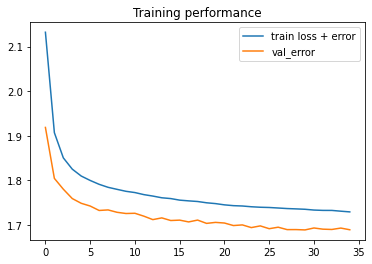

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

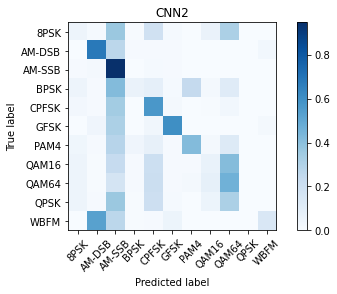

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08506686478454681
Overall Accuracy:  0.09463955637707948


Overall Accuracy:  0.09579356663131848
Overall Accuracy:  0.09732958538299367


Overall Accuracy:  0.11271676300578035
Overall Accuracy:  0.1711421410669531


Overall Accuracy:  0.2418487997133644


Overall Accuracy:  0.329578488372093


Overall Accuracy:  0.4245651402200923


Overall Accuracy:  0.4920920201294033


Overall Accuracy:  0.49201161946259986


Overall Accuracy:  0.5109989181391994


Overall Accuracy:  0.5081593927893738


Overall Accuracy:  0.5082089552238805
Overall Accuracy:  0.5003602305475504


Overall Accuracy:  0.5162231133795114
Overall Accuracy: 

 0.5253609774157719


Overall Accuracy:  0.5114704776231666


Overall Accuracy:  0.5239498894620487


Overall Accuracy:  0.5265232974910394


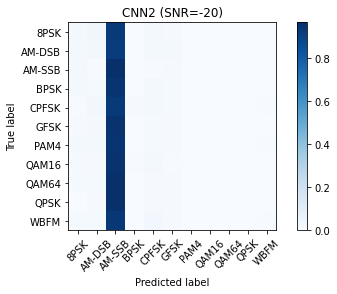

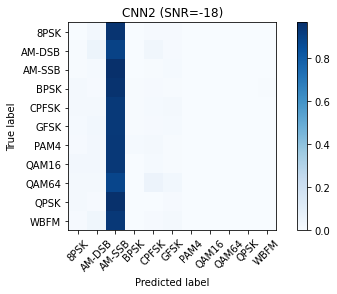

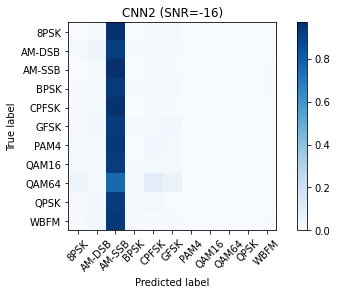

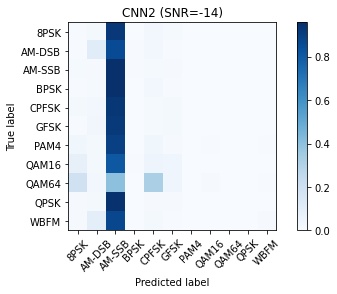

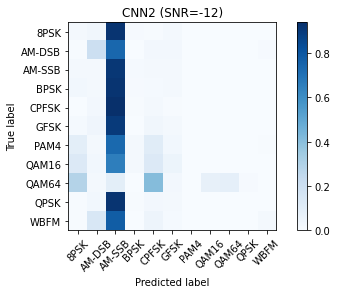

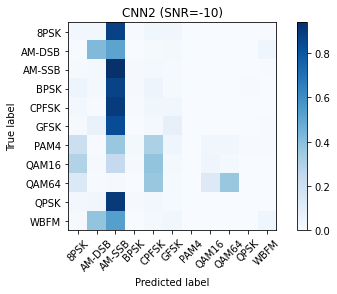

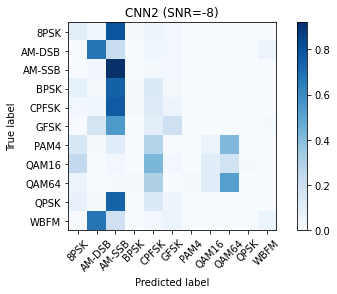

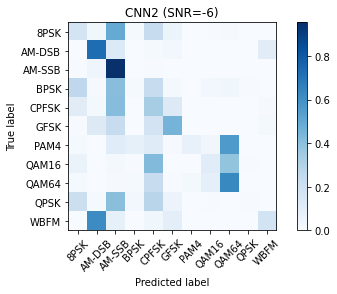

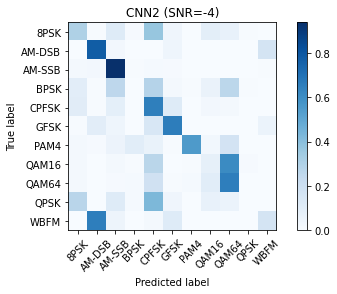

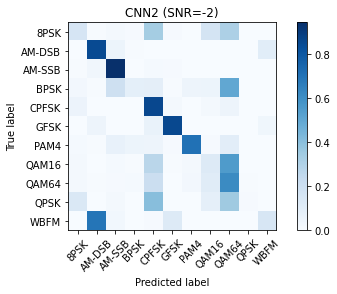

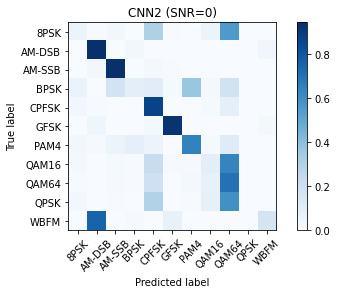

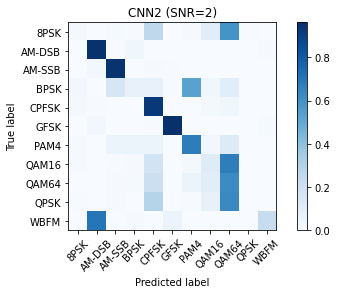

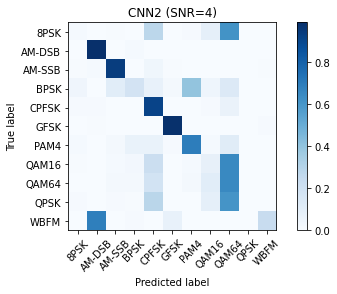

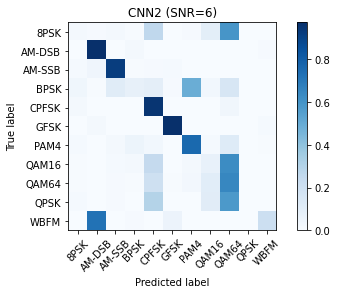

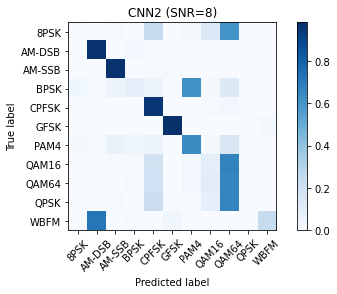

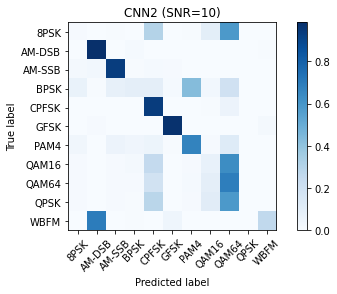

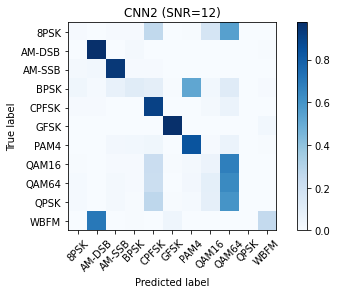

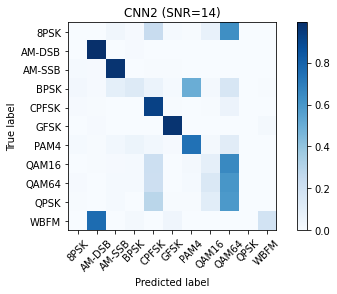

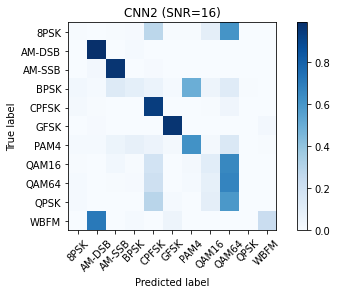

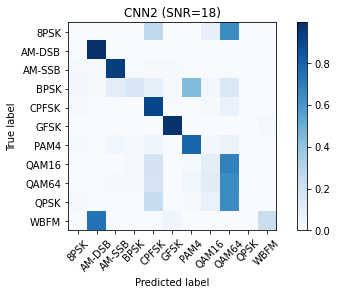

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,9,11,17,24,32,42,49,49,51,50,50,50,51,52,51,52,52


In [18]:
import statistics

statistics.mean(acc.values())

0.36340198986088834

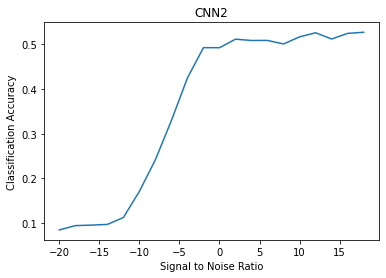

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)